# Trẻ em ăn 1 lần vào sinh nhật mỗi năm (tổng là 3 lần)

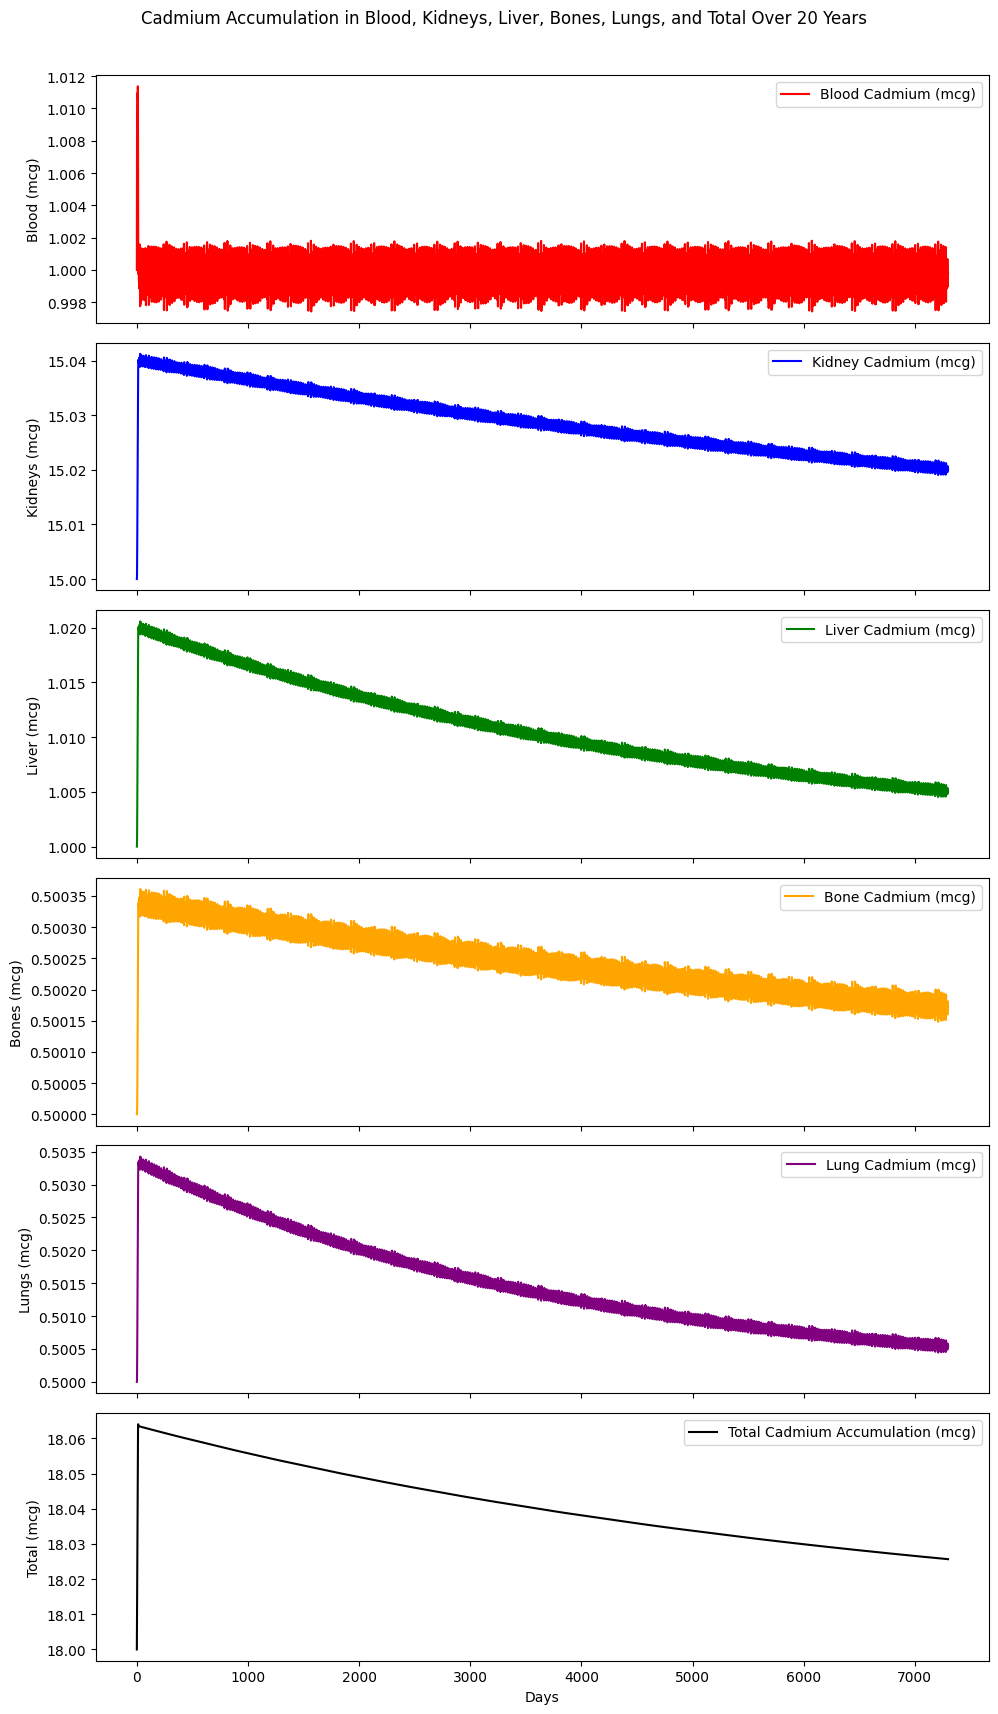

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Nutrient average intakes (mg/day) for children
Fe_avg = 8.5     # Iron
Ca_avg = 900     # Calcium
Zn_avg = 6.5     # Zinc

# Nutrient modulation coefficients
k_Fe = 0.12
k_Ca = 0.06
k_Zn = 0.08

# Baseline cadmium levels (micrograms) in minimally exposed individuals
baseline_kidneys = 15
baseline_liver = 1
baseline_bones = 0.5
baseline_lungs = 0.5
baseline_blood = 1

# Time-varying functions for Fe, Ca, and Zn levels with weekly fluctuations
def Fe_level(t):
    return Fe_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Ca_level(t):
    return Ca_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Zn_level(t):
    return Zn_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

# Parameters for chocolate consumption pattern
n = 1             # Number of times chocolate is consumed
m = 365           # Days between each consumption period (e.g., 1 year)
consumption_duration = 10  # Duration of each consumption period in days

# Baseline daily intake pattern modified to occur n times with m days apart
def baseline_intake(t):
    base_intake = 4.358  # Average cadmium intake in mcg/day from contaminated chocolate
    for i in range(n):
        start_time = i * m
        if start_time <= t < start_time + consumption_duration:
            return base_intake
    return 0  # Cadmium intake is zero outside of the specified periods

# Effective intake with nutrient modulation
def effective_intake(t):
    base = baseline_intake(t)
    modulating_factor = 1 / (1 + k_Fe * Fe_level(t) + k_Ca * Ca_level(t) + k_Zn * Zn_level(t))
    return absorption_rate * base * modulating_factor

# Parameters for cadmium intake and initial absorption
absorption_rate = 0.08  # Cadmium absorption rate into blood (8% for children)

# Maximum total transfer rates and alpha values based on the target timeframes
R_kidneys_liver_lungs = 0.66  # Maximum total transfer rate for kidneys, liver, and lungs (7-day target)
R_bones = 0.154               # Maximum total transfer rate for bones (30-day target)
alpha_fast = 1                # Faster approach for kidneys, liver, and lungs
alpha_slow = 0.1              # Slower approach for bones

# Time-dependent individual transfer rates as fractions of total transfer
def r_k(t):
    return 0.6 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_l(t):
    return 0.3 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_lungs(t):
    return 0.05 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_b(t):
    return 0.05 * R_bones * (1 - np.exp(-alpha_slow * (t - 1))) if t > 1 else 0

# Excretion rates calculated from half-lives (in days)
excretion_rate_kidneys = np.log(2) / 7300   # Average 20-year half-life
excretion_rate_liver = np.log(2) / 3650     # Average 10-year half-life
excretion_rate_bones = np.log(2) / 7300     # Average 20-year half-life
excretion_rate_lungs = np.log(2) / 2737.5   # Average 7.5-year half-life

# System of differential equations with baseline levels
def cadmium_dynamics(t, C):
    C_blood, C_k, C_l, C_b, C_lungs = C
    intake = effective_intake(t)

    # Blood compartment: gradual transfer to organs after day 1, maintaining baseline
    if t <= 1:
        dCblood_dt = intake
    else:
        dCblood_dt = intake - (r_k(t) + r_l(t) + r_b(t) + r_lungs(t)) * (C_blood - baseline_blood)

    # Organ compartments: start accumulating after day 1, with excretion once accumulation begins
    dCk_dt = r_k(t) * (C_blood - baseline_blood) - excretion_rate_kidneys * (C_k - baseline_kidneys)
    dCl_dt = r_l(t) * (C_blood - baseline_blood) - excretion_rate_liver * (C_l - baseline_liver)
    dCb_dt = r_b(t) * (C_blood - baseline_blood) - excretion_rate_bones * (C_b - baseline_bones)
    dClungs_dt = r_lungs(t) * (C_blood - baseline_blood) - excretion_rate_lungs * (C_lungs - baseline_lungs)

    return [dCblood_dt, dCk_dt, dCl_dt, dCb_dt, dClungs_dt]

# Time span for simulation (20 years in days)
time_span = (0, 20 * 365)  # 20 years in days
initial_conditions = [baseline_blood, baseline_kidneys, baseline_liver, baseline_bones, baseline_lungs]

# Solving the system with daily evaluation intervals
solution = solve_ivp(cadmium_dynamics, time_span, initial_conditions, method='RK45', t_eval=np.arange(0, 20 * 365, 1))

# Calculate total cadmium accumulation as the sum of all organs and blood
total_cadmium = solution.y[0] + solution.y[1] + solution.y[2] + solution.y[3] + solution.y[4]

# Plotting each cadmium accumulation in a separate graph
fig, axes = plt.subplots(6, 1, figsize=(10, 18), sharex=True)

axes[0].plot(solution.t, solution.y[0], label="Blood Cadmium (mcg)", color="red")
axes[0].set_ylabel("Blood (mcg)")
axes[0].legend()

axes[1].plot(solution.t, solution.y[1], label="Kidney Cadmium (mcg)", color="blue")
axes[1].set_ylabel("Kidneys (mcg)")
axes[1].legend()

axes[2].plot(solution.t, solution.y[2], label="Liver Cadmium (mcg)", color="green")
axes[2].set_ylabel("Liver (mcg)")
axes[2].legend()

axes[3].plot(solution.t, solution.y[3], label="Bone Cadmium (mcg)", color="orange")
axes[3].set_ylabel("Bones (mcg)")
axes[3].legend()

axes[4].plot(solution.t, solution.y[4], label="Lung Cadmium (mcg)", color="purple")
axes[4].set_ylabel("Lungs (mcg)")
axes[4].legend()

axes[5].plot(solution.t, total_cadmium, label="Total Cadmium Accumulation (mcg)", color="black")
axes[5].set_ylabel("Total (mcg)")
axes[5].set_xlabel("Days")
axes[5].legend()

fig.suptitle("Cadmium Accumulation in Blood, Kidneys, Liver, Bones, Lungs, and Total Over 20 Years")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# Trẻ em ăn dồn vào 1 ngày lễ sau đó không ăn nữa


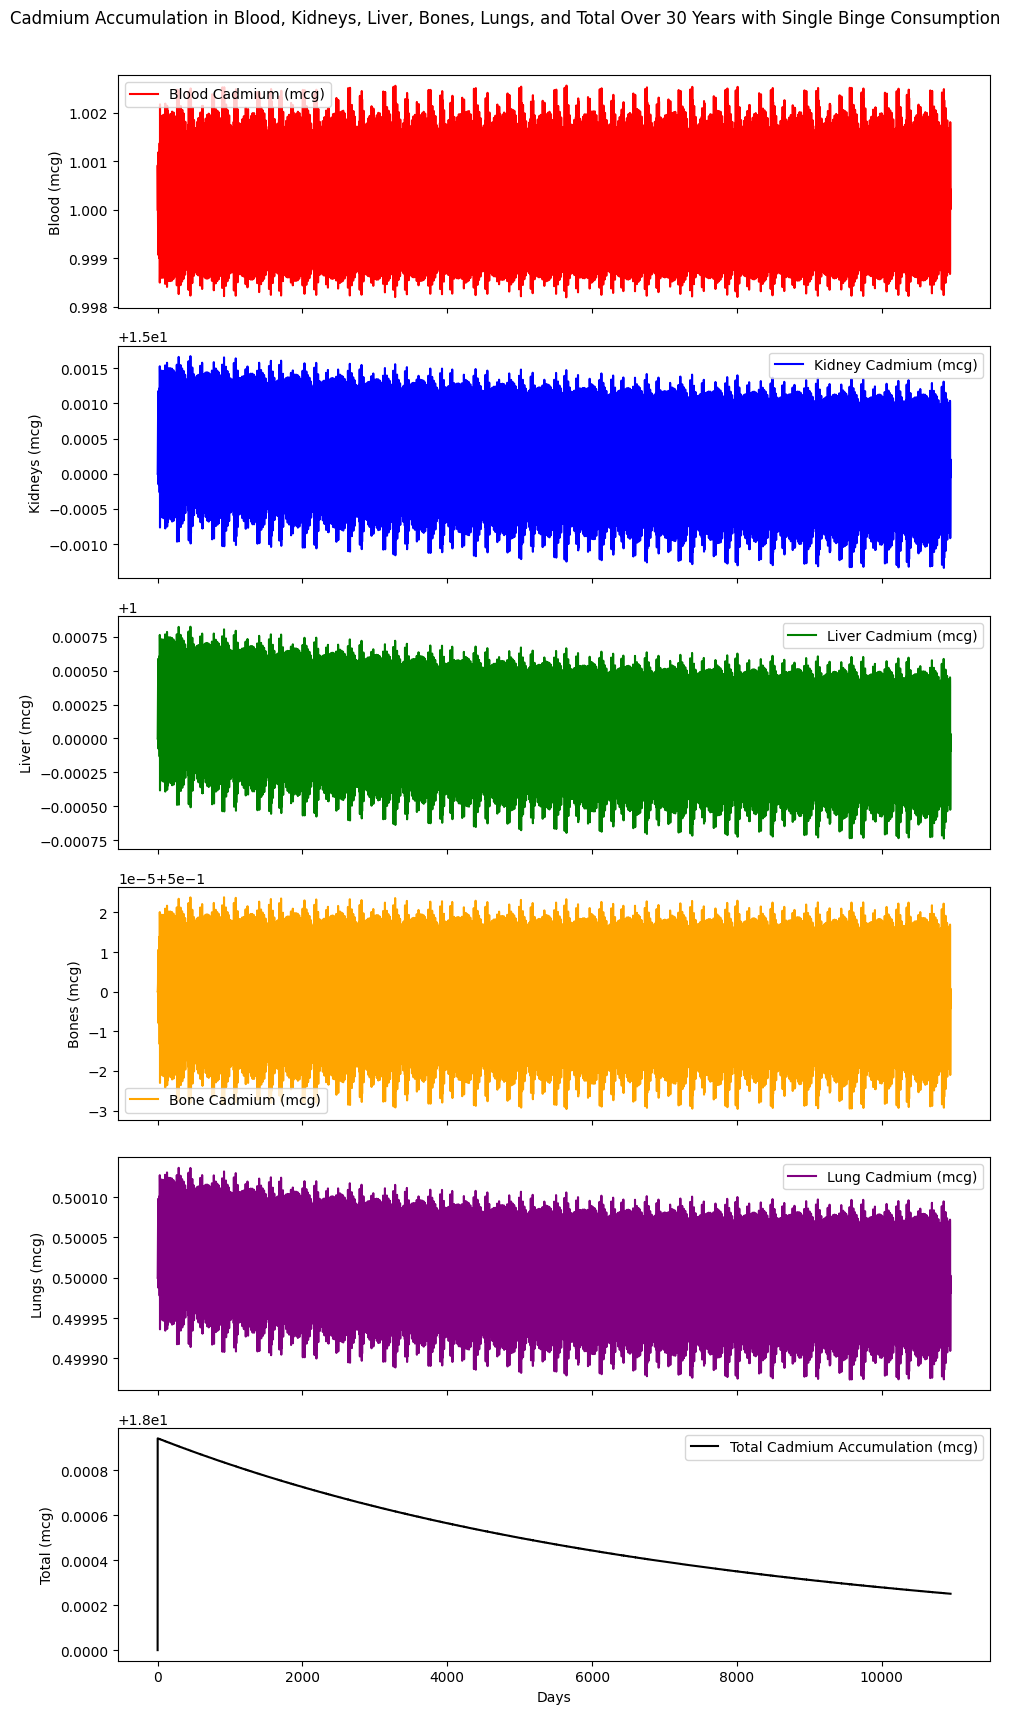

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Nutrient average intakes (mg/day) for children
Fe_avg = 8.5     # Iron
Ca_avg = 900     # Calcium
Zn_avg = 6.5     # Zinc

# Nutrient modulation coefficients
k_Fe = 0.12
k_Ca = 0.06
k_Zn = 0.08

# Baseline cadmium levels (micrograms) in minimally exposed individuals
baseline_kidneys = 15
baseline_liver = 1
baseline_bones = 0.5
baseline_lungs = 0.5
baseline_blood = 1

# Time-varying functions for Fe, Ca, and Zn levels with weekly fluctuations
def Fe_level(t):
    return Fe_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Ca_level(t):
    return Ca_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Zn_level(t):
    return Zn_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

# Single binge consumption pattern for one day
def baseline_intake(t):
    # Set a super high intake for only the first day, then zero afterward
    if t == 0:
        return 10 * 4.358  # 10 times the normal intake
    return 0

# Effective intake with nutrient modulation
def effective_intake(t):
    base = baseline_intake(t)
    modulating_factor = 1 / (1 + k_Fe * Fe_level(t) + k_Ca * Ca_level(t) + k_Zn * Zn_level(t))
    return absorption_rate * base * modulating_factor

# Parameters for cadmium intake and initial absorption
absorption_rate = 0.08  # Cadmium absorption rate into blood (8% for children)

# Maximum total transfer rates and alpha values based on the target timeframes
R_kidneys_liver_lungs = 0.66  # Maximum total transfer rate for kidneys, liver, and lungs (7-day target)
R_bones = 0.154               # Maximum total transfer rate for bones (30-day target)
alpha_fast = 1                # Faster approach for kidneys, liver, and lungs
alpha_slow = 0.1              # Slower approach for bones

# Time-dependent individual transfer rates as fractions of total transfer
def r_k(t):
    return 0.6 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_l(t):
    return 0.3 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_lungs(t):
    return 0.05 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_b(t):
    return 0.05 * R_bones * (1 - np.exp(-alpha_slow * (t - 1))) if t > 1 else 0

# Excretion rates calculated from half-lives (in days)
excretion_rate_kidneys = np.log(2) / 7300   # Average 20-year half-life
excretion_rate_liver = np.log(2) / 3650     # Average 10-year half-life
excretion_rate_bones = np.log(2) / 7300     # Average 20-year half-life
excretion_rate_lungs = np.log(2) / 2737.5   # Average 7.5-year half-life

# System of differential equations with baseline levels
def cadmium_dynamics(t, C):
    C_blood, C_k, C_l, C_b, C_lungs = C
    intake = effective_intake(t)

    # Blood compartment: gradual transfer to organs after day 1, maintaining baseline
    if t <= 1:
        dCblood_dt = intake
    else:
        dCblood_dt = intake - (r_k(t) + r_l(t) + r_b(t) + r_lungs(t)) * (C_blood - baseline_blood)

    # Organ compartments: start accumulating after day 1, with excretion once accumulation begins
    dCk_dt = r_k(t) * (C_blood - baseline_blood) - excretion_rate_kidneys * (C_k - baseline_kidneys)
    dCl_dt = r_l(t) * (C_blood - baseline_blood) - excretion_rate_liver * (C_l - baseline_liver)
    dCb_dt = r_b(t) * (C_blood - baseline_blood) - excretion_rate_bones * (C_b - baseline_bones)
    dClungs_dt = r_lungs(t) * (C_blood - baseline_blood) - excretion_rate_lungs * (C_lungs - baseline_lungs)

    return [dCblood_dt, dCk_dt, dCl_dt, dCb_dt, dClungs_dt]

# Time span for simulation (30 years in days)
time_span = (0, 30 * 365)  # 30 years in days
initial_conditions = [baseline_blood, baseline_kidneys, baseline_liver, baseline_bones, baseline_lungs]

# Solving the system with daily evaluation intervals
solution = solve_ivp(cadmium_dynamics, time_span, initial_conditions, method='RK45', t_eval=np.arange(0, 30 * 365, 1))

# Calculate total cadmium accumulation as the sum of all organs and blood
total_cadmium = solution.y[0] + solution.y[1] + solution.y[2] + solution.y[3] + solution.y[4]

# Plotting each cadmium accumulation in a separate graph
fig, axes = plt.subplots(6, 1, figsize=(10, 18), sharex=True)

axes[0].plot(solution.t, solution.y[0], label="Blood Cadmium (mcg)", color="red")
axes[0].set_ylabel("Blood (mcg)")
axes[0].legend()

axes[1].plot(solution.t, solution.y[1], label="Kidney Cadmium (mcg)", color="blue")
axes[1].set_ylabel("Kidneys (mcg)")
axes[1].legend()

axes[2].plot(solution.t, solution.y[2], label="Liver Cadmium (mcg)", color="green")
axes[2].set_ylabel("Liver (mcg)")
axes[2].legend()

axes[3].plot(solution.t, solution.y[3], label="Bone Cadmium (mcg)", color="orange")
axes[3].set_ylabel("Bones (mcg)")
axes[3].legend()

axes[4].plot(solution.t, solution.y[4], label="Lung Cadmium (mcg)", color="purple")
axes[4].set_ylabel("Lungs (mcg)")
axes[4].legend()

axes[5].plot(solution.t, total_cadmium, label="Total Cadmium Accumulation (mcg)", color="black")
axes[5].set_ylabel("Total (mcg)")
axes[5].set_xlabel("Days")
axes[5].legend()

fig.suptitle("Cadmium Accumulation in Blood, Kidneys, Liver, Bones, Lungs, and Total Over 30 Years with Single Binge Consumption")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# Trẻ em ăn liên tục


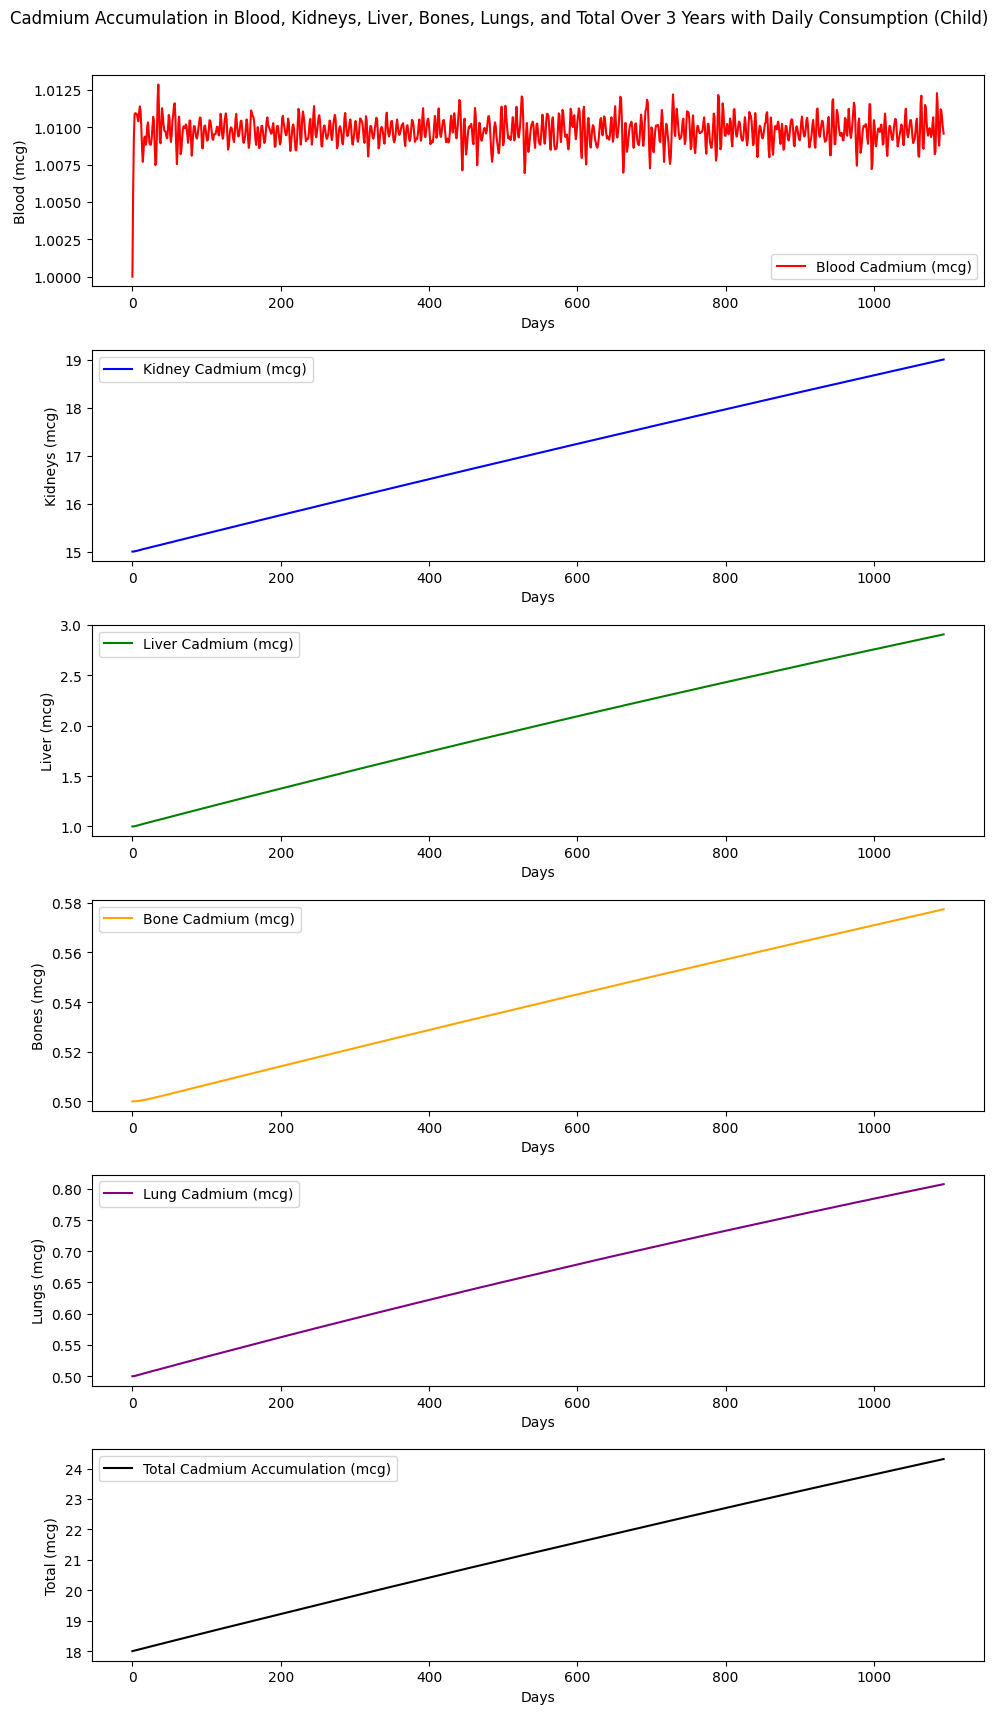

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Nutrient average intakes (mg/day) for children
Fe_avg = 8.5     # Iron
Ca_avg = 900     # Calcium
Zn_avg = 6.5     # Zinc

# Nutrient modulation coefficients
k_Fe = 0.12
k_Ca = 0.06
k_Zn = 0.08

# Baseline cadmium levels (micrograms) in minimally exposed children
baseline_kidneys = 15
baseline_liver = 1
baseline_bones = 0.5
baseline_lungs = 0.5
baseline_blood = 1

# Time-varying functions for Fe, Ca, and Zn levels with weekly fluctuations
def Fe_level(t):
    return Fe_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Ca_level(t):
    return Ca_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Zn_level(t):
    return Zn_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

# Daily intake of cadmium from chocolate for children
def baseline_intake(t):
    return 4.358  # Updated average cadmium intake in mcg/day for children from contaminated chocolate

# Effective intake with nutrient modulation
def effective_intake(t):
    base = baseline_intake(t)
    modulating_factor = 1 / (1 + k_Fe * Fe_level(t) + k_Ca * Ca_level(t) + k_Zn * Zn_level(t))
    return absorption_rate * base * modulating_factor

# Parameters for cadmium intake and initial absorption for children
absorption_rate = 0.08  # Cadmium absorption rate into blood (8% for children)

# Maximum total transfer rates and alpha values based on the target timeframes
R_kidneys_liver_lungs = 0.66  # Maximum total transfer rate for kidneys, liver, and lungs (7-day target)
R_bones = 0.154               # Maximum total transfer rate for bones (30-day target)
alpha_fast = 1                # Faster approach for kidneys, liver, and lungs
alpha_slow = 0.1              # Slower approach for bones

# Time-dependent individual transfer rates as fractions of total transfer
def r_k(t):
    return 0.6 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_l(t):
    return 0.3 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_lungs(t):
    return 0.05 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_b(t):
    return 0.05 * R_bones * (1 - np.exp(-alpha_slow * (t - 1))) if t > 1 else 0

# Excretion rates calculated from half-lives (in days)
excretion_rate_kidneys = np.log(2) / 7300   # Average 20-year half-life
excretion_rate_liver = np.log(2) / 3650     # Average 10-year half-life
excretion_rate_bones = np.log(2) / 7300     # Average 20-year half-life
excretion_rate_lungs = np.log(2) / 2737.5   # Average 7.5-year half-life

# System of differential equations with baseline levels
def cadmium_dynamics(t, C):
    C_blood, C_k, C_l, C_b, C_lungs = C
    intake = effective_intake(t)

    # Blood compartment: gradual transfer to organs after day 1, maintaining baseline
    if t <= 1:
        dCblood_dt = intake
    else:
        dCblood_dt = intake - (r_k(t) + r_l(t) + r_b(t) + r_lungs(t)) * (C_blood - baseline_blood)

    # Organ compartments: start accumulating after day 1, with excretion once accumulation begins
    dCk_dt = r_k(t) * (C_blood - baseline_blood) - excretion_rate_kidneys * (C_k - baseline_kidneys)
    dCl_dt = r_l(t) * (C_blood - baseline_blood) - excretion_rate_liver * (C_l - baseline_liver)
    dCb_dt = r_b(t) * (C_blood - baseline_blood) - excretion_rate_bones * (C_b - baseline_bones)
    dClungs_dt = r_lungs(t) * (C_blood - baseline_blood) - excretion_rate_lungs * (C_lungs - baseline_lungs)

    return [dCblood_dt, dCk_dt, dCl_dt, dCb_dt, dClungs_dt]

# Time span for simulation (20 years in days)
time_span = (0, 3 * 365)  # 20 years in days
initial_conditions = [baseline_blood, baseline_kidneys, baseline_liver, baseline_bones, baseline_lungs]

# Solving the system with daily evaluation intervals
solution = solve_ivp(cadmium_dynamics, time_span, initial_conditions, method='RK45', t_eval=np.arange(0, 3 * 365, 1))

# Calculate total cadmium accumulation as the sum of all organs and blood
total_cadmium = solution.y[0] + solution.y[1] + solution.y[2] + solution.y[3] + solution.y[4]

# Plotting each cadmium accumulation in a separate graph without shared x-axis
fig, axes = plt.subplots(6, 1, figsize=(10, 18))

axes[0].plot(solution.t, solution.y[0], label="Blood Cadmium (mcg)", color="red")
axes[0].set_ylabel("Blood (mcg)")
axes[0].legend()
axes[0].set_xlabel("Days")

axes[1].plot(solution.t, solution.y[1], label="Kidney Cadmium (mcg)", color="blue")
axes[1].set_ylabel("Kidneys (mcg)")
axes[1].legend()
axes[1].set_xlabel("Days")

axes[2].plot(solution.t, solution.y[2], label="Liver Cadmium (mcg)", color="green")
axes[2].set_ylabel("Liver (mcg)")
axes[2].legend()
axes[2].set_xlabel("Days")

axes[3].plot(solution.t, solution.y[3], label="Bone Cadmium (mcg)", color="orange")
axes[3].set_ylabel("Bones (mcg)")
axes[3].legend()
axes[3].set_xlabel("Days")

axes[4].plot(solution.t, solution.y[4], label="Lung Cadmium (mcg)", color="purple")
axes[4].set_ylabel("Lungs (mcg)")
axes[4].legend()
axes[4].set_xlabel("Days")

axes[5].plot(solution.t, total_cadmium, label="Total Cadmium Accumulation (mcg)", color="black")
axes[5].set_ylabel("Total (mcg)")
axes[5].set_xlabel("Days")
axes[5].legend()

fig.suptitle("Cadmium Accumulation in Blood, Kidneys, Liver, Bones, Lungs, and Total Over 3 Years with Daily Consumption (Child)")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


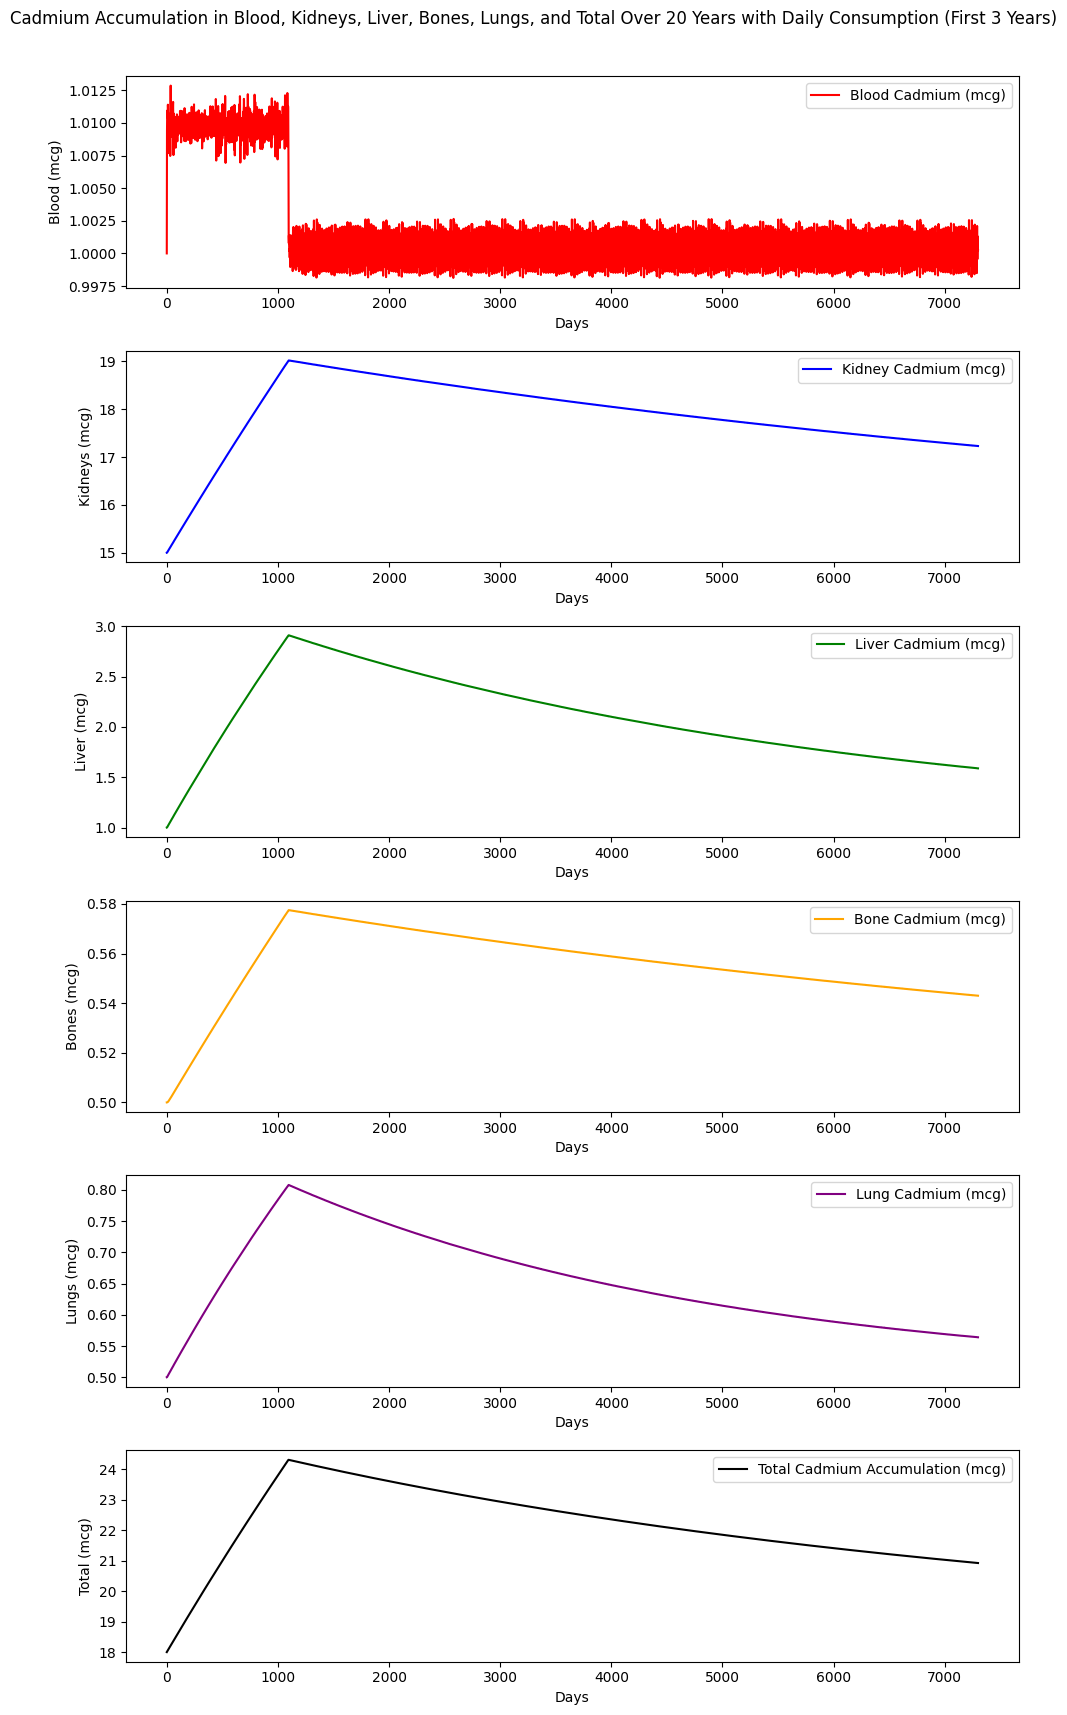

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Nutrient average intakes (mg/day) for children
Fe_avg = 8.5     # Iron
Ca_avg = 900     # Calcium
Zn_avg = 6.5     # Zinc

# Nutrient modulation coefficients
k_Fe = 0.12
k_Ca = 0.06
k_Zn = 0.08

# Baseline cadmium levels (micrograms) in minimally exposed children
baseline_kidneys = 15
baseline_liver = 1
baseline_bones = 0.5
baseline_lungs = 0.5
baseline_blood = 1

# Time-varying functions for Fe, Ca, and Zn levels with weekly fluctuations
def Fe_level(t):
    return Fe_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Ca_level(t):
    return Ca_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Zn_level(t):
    return Zn_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

# Daily cadmium intake for continuous consumption over 3 years
def baseline_intake(t):
    # Regular daily intake for the first 3 years only
    if t < 3 * 365:
        daily_intake = 4.358  # mcg/day from daily chocolate consumption
        return daily_intake
    else:
        return 0  # No intake after the first 3 years

# Effective intake with nutrient modulation
def effective_intake(t):
    base = baseline_intake(t)
    modulating_factor = 1 / (1 + k_Fe * Fe_level(t) + k_Ca * Ca_level(t) + k_Zn * Zn_level(t))
    return absorption_rate * base * modulating_factor

# Parameters for cadmium intake and initial absorption for children
absorption_rate = 0.08  # Cadmium absorption rate into blood (8% for children)

# Maximum total transfer rates and alpha values based on the target timeframes
R_kidneys_liver_lungs = 0.66  # Maximum total transfer rate for kidneys, liver, and lungs (7-day target)
R_bones = 0.154               # Maximum total transfer rate for bones (30-day target)
alpha_fast = 1                # Faster approach for kidneys, liver, and lungs
alpha_slow = 0.1              # Slower approach for bones

# Time-dependent individual transfer rates as fractions of total transfer
def r_k(t):
    return 0.6 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_l(t):
    return 0.3 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_lungs(t):
    return 0.05 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_b(t):
    return 0.05 * R_bones * (1 - np.exp(-alpha_slow * (t - 1))) if t > 1 else 0

# Excretion rates calculated from half-lives (in days)
excretion_rate_kidneys = np.log(2) / 7300   # Average 20-year half-life
excretion_rate_liver = np.log(2) / 3650     # Average 10-year half-life
excretion_rate_bones = np.log(2) / 7300     # Average 20-year half-life
excretion_rate_lungs = np.log(2) / 2737.5   # Average 7.5-year half-life

# System of differential equations with baseline levels
def cadmium_dynamics(t, C):
    C_blood, C_k, C_l, C_b, C_lungs = C
    intake = effective_intake(t)

    # Blood compartment: gradual transfer to organs after day 1, maintaining baseline
    if t <= 1:
        dCblood_dt = intake
    else:
        dCblood_dt = intake - (r_k(t) + r_l(t) + r_b(t) + r_lungs(t)) * (C_blood - baseline_blood)

    # Organ compartments: start accumulating after day 1, with excretion once accumulation begins
    dCk_dt = r_k(t) * (C_blood - baseline_blood) - excretion_rate_kidneys * (C_k - baseline_kidneys)
    dCl_dt = r_l(t) * (C_blood - baseline_blood) - excretion_rate_liver * (C_l - baseline_liver)
    dCb_dt = r_b(t) * (C_blood - baseline_blood) - excretion_rate_bones * (C_b - baseline_bones)
    dClungs_dt = r_lungs(t) * (C_blood - baseline_blood) - excretion_rate_lungs * (C_lungs - baseline_lungs)

    return [dCblood_dt, dCk_dt, dCl_dt, dCb_dt, dClungs_dt]

# Time span for simulation (20 years in days)
time_span = (0, 20 * 365)  # 20 years in days
initial_conditions = [baseline_blood, baseline_kidneys, baseline_liver, baseline_bones, baseline_lungs]

# Solving the system with daily evaluation intervals
solution = solve_ivp(cadmium_dynamics, time_span, initial_conditions, method='RK45', t_eval=np.arange(0, 20 * 365, 1))

# Calculate total cadmium accumulation as the sum of all organs and blood
total_cadmium = solution.y[0] + solution.y[1] + solution.y[2] + solution.y[3] + solution.y[4]

# Plotting each cadmium accumulation in a separate graph without shared x-axis
fig, axes = plt.subplots(6, 1, figsize=(10, 18))

axes[0].plot(solution.t, solution.y[0], label="Blood Cadmium (mcg)", color="red")
axes[0].set_ylabel("Blood (mcg)")
axes[0].legend()
axes[0].set_xlabel("Days")

axes[1].plot(solution.t, solution.y[1], label="Kidney Cadmium (mcg)", color="blue")
axes[1].set_ylabel("Kidneys (mcg)")
axes[1].legend()
axes[1].set_xlabel("Days")

axes[2].plot(solution.t, solution.y[2], label="Liver Cadmium (mcg)", color="green")
axes[2].set_ylabel("Liver (mcg)")
axes[2].legend()
axes[2].set_xlabel("Days")

axes[3].plot(solution.t, solution.y[3], label="Bone Cadmium (mcg)", color="orange")
axes[3].set_ylabel("Bones (mcg)")
axes[3].legend()
axes[3].set_xlabel("Days")

axes[4].plot(solution.t, solution.y[4], label="Lung Cadmium (mcg)", color="purple")
axes[4].set_ylabel("Lungs (mcg)")
axes[4].legend()
axes[4].set_xlabel("Days")

axes[5].plot(solution.t, total_cadmium, label="Total Cadmium Accumulation (mcg)", color="black")
axes[5].set_ylabel("Total (mcg)")
axes[5].set_xlabel("Days")
axes[5].legend()

fig.suptitle("Cadmium Accumulation in Blood, Kidneys, Liver, Bones, Lungs, and Total Over 20 Years with Daily Consumption (First 3 Years)")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# Người lớn ăn liên tục

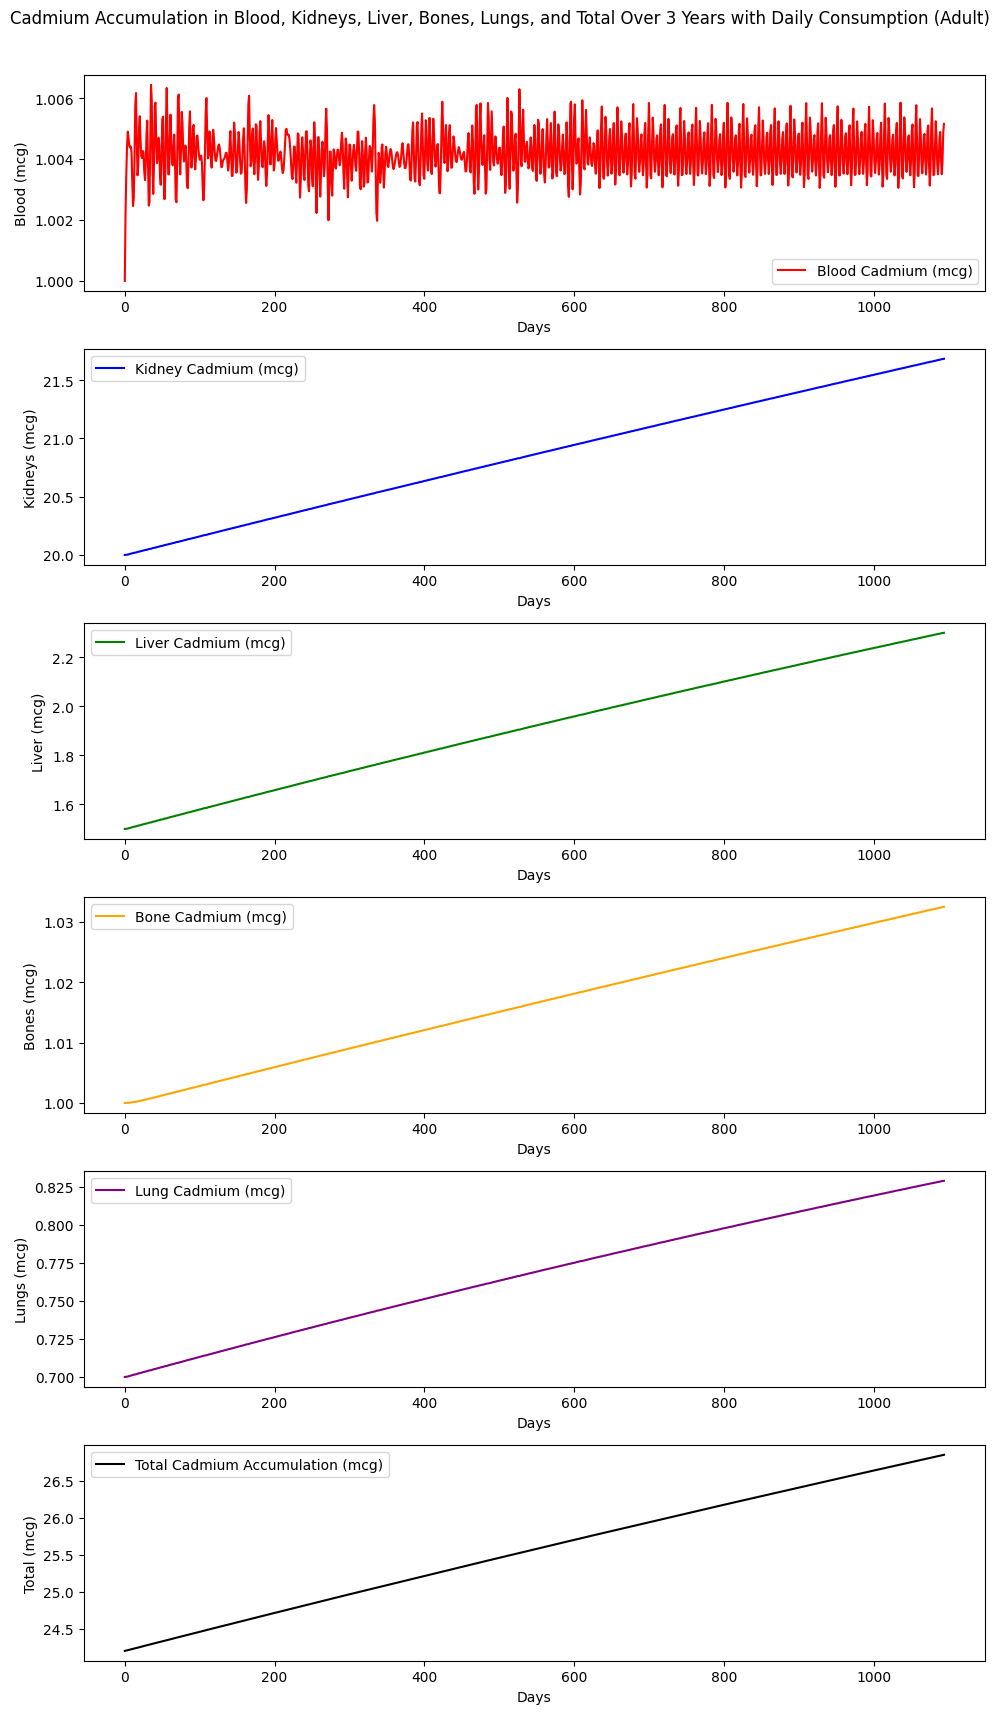

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Nutrient average intakes (mg/day) for adults
Fe_avg = 10.0    # Iron
Ca_avg = 1000    # Calcium
Zn_avg = 9.0     # Zinc

# Nutrient modulation coefficients
k_Fe = 0.10
k_Ca = 0.05
k_Zn = 0.07

# Baseline cadmium levels (micrograms) in minimally exposed adults
baseline_kidneys = 20
baseline_liver = 1.5
baseline_bones = 1
baseline_lungs = 0.7
baseline_blood = 1

# Time-varying functions for Fe, Ca, and Zn levels with weekly fluctuations
def Fe_level(t):
    return Fe_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Ca_level(t):
    return Ca_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Zn_level(t):
    return Zn_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

# Daily intake of cadmium from chocolate for adults
def baseline_intake(t):
    return 2.725  # Average cadmium intake in mcg/day for adults from contaminated chocolate

# Effective intake with nutrient modulation
def effective_intake(t):
    base = baseline_intake(t)
    modulating_factor = 1 / (1 + k_Fe * Fe_level(t) + k_Ca * Ca_level(t) + k_Zn * Zn_level(t))
    return absorption_rate * base * modulating_factor

# Parameters for cadmium intake and initial absorption for adults
absorption_rate = 0.05  # Cadmium absorption rate into blood (5% for adults)

# Maximum total transfer rates and alpha values based on the target timeframes
R_kidneys_liver_lungs = 0.66  # Maximum total transfer rate for kidneys, liver, and lungs (7-day target)
R_bones = 0.154               # Maximum total transfer rate for bones (30-day target)
alpha_fast = 1                # Faster approach for kidneys, liver, and lungs
alpha_slow = 0.1              # Slower approach for bones

# Time-dependent individual transfer rates as fractions of total transfer
def r_k(t):
    return 0.6 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_l(t):
    return 0.3 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_lungs(t):
    return 0.05 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_b(t):
    return 0.05 * R_bones * (1 - np.exp(-alpha_slow * (t - 1))) if t > 1 else 0

# Excretion rates calculated from half-lives (in days)
excretion_rate_kidneys = np.log(2) / 7300   # Average 20-year half-life
excretion_rate_liver = np.log(2) / 3650     # Average 10-year half-life
excretion_rate_bones = np.log(2) / 7300     # Average 20-year half-life
excretion_rate_lungs = np.log(2) / 2737.5   # Average 7.5-year half-life

# System of differential equations with baseline levels
def cadmium_dynamics(t, C):
    C_blood, C_k, C_l, C_b, C_lungs = C
    intake = effective_intake(t)

    # Blood compartment: gradual transfer to organs after day 1, maintaining baseline
    if t <= 1:
        dCblood_dt = intake
    else:
        dCblood_dt = intake - (r_k(t) + r_l(t) + r_b(t) + r_lungs(t)) * (C_blood - baseline_blood)

    # Organ compartments: start accumulating after day 1, with excretion once accumulation begins
    dCk_dt = r_k(t) * (C_blood - baseline_blood) - excretion_rate_kidneys * (C_k - baseline_kidneys)
    dCl_dt = r_l(t) * (C_blood - baseline_blood) - excretion_rate_liver * (C_l - baseline_liver)
    dCb_dt = r_b(t) * (C_blood - baseline_blood) - excretion_rate_bones * (C_b - baseline_bones)
    dClungs_dt = r_lungs(t) * (C_blood - baseline_blood) - excretion_rate_lungs * (C_lungs - baseline_lungs)

    return [dCblood_dt, dCk_dt, dCl_dt, dCb_dt, dClungs_dt]

# Time span for simulation (3 years in days)
time_span = (0, 3 * 365)  # 3 years in days
initial_conditions = [baseline_blood, baseline_kidneys, baseline_liver, baseline_bones, baseline_lungs]

# Solving the system with daily evaluation intervals
solution = solve_ivp(cadmium_dynamics, time_span, initial_conditions, method='RK45', t_eval=np.arange(0, 3 * 365, 1))

# Calculate total cadmium accumulation as the sum of all organs and blood
total_cadmium = solution.y[0] + solution.y[1] + solution.y[2] + solution.y[3] + solution.y[4]

# Plotting each cadmium accumulation in a separate graph without shared x-axis
fig, axes = plt.subplots(6, 1, figsize=(10, 18))

axes[0].plot(solution.t, solution.y[0], label="Blood Cadmium (mcg)", color="red")
axes[0].set_ylabel("Blood (mcg)")
axes[0].legend()
axes[0].set_xlabel("Days")

axes[1].plot(solution.t, solution.y[1], label="Kidney Cadmium (mcg)", color="blue")
axes[1].set_ylabel("Kidneys (mcg)")
axes[1].legend()
axes[1].set_xlabel("Days")

axes[2].plot(solution.t, solution.y[2], label="Liver Cadmium (mcg)", color="green")
axes[2].set_ylabel("Liver (mcg)")
axes[2].legend()
axes[2].set_xlabel("Days")

axes[3].plot(solution.t, solution.y[3], label="Bone Cadmium (mcg)", color="orange")
axes[3].set_ylabel("Bones (mcg)")
axes[3].legend()
axes[3].set_xlabel("Days")

axes[4].plot(solution.t, solution.y[4], label="Lung Cadmium (mcg)", color="purple")
axes[4].set_ylabel("Lungs (mcg)")
axes[4].legend()
axes[4].set_xlabel("Days")

axes[5].plot(solution.t, total_cadmium, label="Total Cadmium Accumulation (mcg)", color="black")
axes[5].set_ylabel("Total (mcg)")
axes[5].set_xlabel("Days")
axes[5].legend()

fig.suptitle("Cadmium Accumulation in Blood, Kidneys, Liver, Bones, Lungs, and Total Over 3 Years with Daily Consumption (Adult)")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


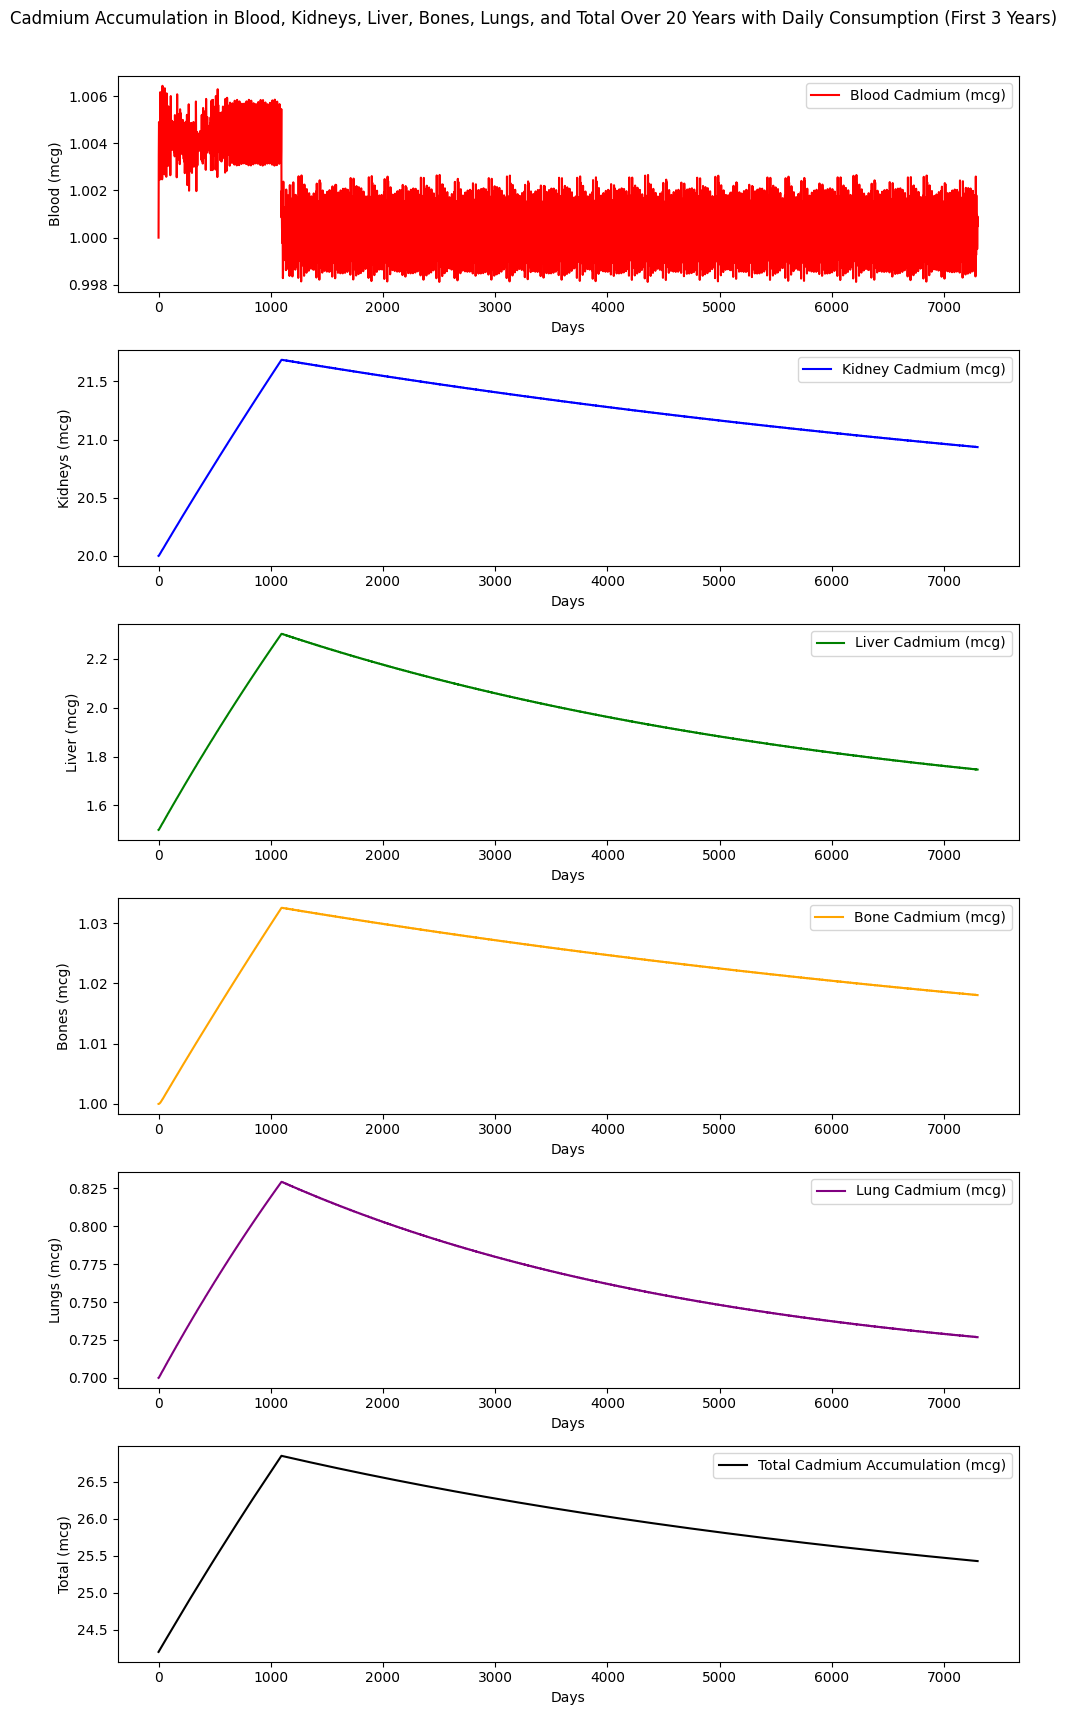

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Nutrient average intakes (mg/day) for adults
Fe_avg = 10.0    # Iron
Ca_avg = 1000    # Calcium
Zn_avg = 9.0     # Zinc

# Nutrient modulation coefficients
k_Fe = 0.10
k_Ca = 0.05
k_Zn = 0.07

# Baseline cadmium levels (micrograms) in minimally exposed adults
baseline_kidneys = 20
baseline_liver = 1.5
baseline_bones = 1
baseline_lungs = 0.7
baseline_blood = 1

# Time-varying functions for Fe, Ca, and Zn levels with weekly fluctuations
def Fe_level(t):
    return Fe_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Ca_level(t):
    return Ca_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Zn_level(t):
    return Zn_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

# Daily cadmium intake for continuous consumption over 3 years
def baseline_intake(t):
    # Regular daily intake for the first 3 years only
    if t < 3 * 365:
        daily_intake = 2.725  # mcg/day from daily chocolate consumption for adults
        return daily_intake
    else:
        return 0  # No intake after the first 3 years

# Effective intake with nutrient modulation
def effective_intake(t):
    base = baseline_intake(t)
    modulating_factor = 1 / (1 + k_Fe * Fe_level(t) + k_Ca * Ca_level(t) + k_Zn * Zn_level(t))
    return absorption_rate * base * modulating_factor

# Parameters for cadmium intake and initial absorption for adults
absorption_rate = 0.05  # Cadmium absorption rate into blood (5% for adults)

# Maximum total transfer rates and alpha values based on the target timeframes
R_kidneys_liver_lungs = 0.66  # Maximum total transfer rate for kidneys, liver, and lungs (7-day target)
R_bones = 0.154               # Maximum total transfer rate for bones (30-day target)
alpha_fast = 1                # Faster approach for kidneys, liver, and lungs
alpha_slow = 0.1              # Slower approach for bones

# Time-dependent individual transfer rates as fractions of total transfer
def r_k(t):
    return 0.6 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_l(t):
    return 0.3 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_lungs(t):
    return 0.05 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_b(t):
    return 0.05 * R_bones * (1 - np.exp(-alpha_slow * (t - 1))) if t > 1 else 0

# Excretion rates calculated from half-lives (in days)
excretion_rate_kidneys = np.log(2) / 7300   # Average 20-year half-life
excretion_rate_liver = np.log(2) / 3650     # Average 10-year half-life
excretion_rate_bones = np.log(2) / 7300     # Average 20-year half-life
excretion_rate_lungs = np.log(2) / 2737.5   # Average 7.5-year half-life

# System of differential equations with baseline levels
def cadmium_dynamics(t, C):
    C_blood, C_k, C_l, C_b, C_lungs = C
    intake = effective_intake(t)

    # Blood compartment: gradual transfer to organs after day 1, maintaining baseline
    if t <= 1:
        dCblood_dt = intake
    else:
        dCblood_dt = intake - (r_k(t) + r_l(t) + r_b(t) + r_lungs(t)) * (C_blood - baseline_blood)

    # Organ compartments: start accumulating after day 1, with excretion once accumulation begins
    dCk_dt = r_k(t) * (C_blood - baseline_blood) - excretion_rate_kidneys * (C_k - baseline_kidneys)
    dCl_dt = r_l(t) * (C_blood - baseline_blood) - excretion_rate_liver * (C_l - baseline_liver)
    dCb_dt = r_b(t) * (C_blood - baseline_blood) - excretion_rate_bones * (C_b - baseline_bones)
    dClungs_dt = r_lungs(t) * (C_blood - baseline_blood) - excretion_rate_lungs * (C_lungs - baseline_lungs)

    return [dCblood_dt, dCk_dt, dCl_dt, dCb_dt, dClungs_dt]

# Time span for simulation (20 years in days)
time_span = (0, 20 * 365)  # 20 years in days
initial_conditions = [baseline_blood, baseline_kidneys, baseline_liver, baseline_bones, baseline_lungs]

# Solving the system with daily evaluation intervals
solution = solve_ivp(cadmium_dynamics, time_span, initial_conditions, method='RK45', t_eval=np.arange(0, 20 * 365, 1))

# Calculate total cadmium accumulation as the sum of all organs and blood
total_cadmium = solution.y[0] + solution.y[1] + solution.y[2] + solution.y[3] + solution.y[4]

# Plotting each cadmium accumulation in a separate graph without shared x-axis
fig, axes = plt.subplots(6, 1, figsize=(10, 18))

axes[0].plot(solution.t, solution.y[0], label="Blood Cadmium (mcg)", color="red")
axes[0].set_ylabel("Blood (mcg)")
axes[0].legend()
axes[0].set_xlabel("Days")

axes[1].plot(solution.t, solution.y[1], label="Kidney Cadmium (mcg)", color="blue")
axes[1].set_ylabel("Kidneys (mcg)")
axes[1].legend()
axes[1].set_xlabel("Days")

axes[2].plot(solution.t, solution.y[2], label="Liver Cadmium (mcg)", color="green")
axes[2].set_ylabel("Liver (mcg)")
axes[2].legend()
axes[2].set_xlabel("Days")

axes[3].plot(solution.t, solution.y[3], label="Bone Cadmium (mcg)", color="orange")
axes[3].set_ylabel("Bones (mcg)")
axes[3].legend()
axes[3].set_xlabel("Days")

axes[4].plot(solution.t, solution.y[4], label="Lung Cadmium (mcg)", color="purple")
axes[4].set_ylabel("Lungs (mcg)")
axes[4].legend()
axes[4].set_xlabel("Days")

axes[5].plot(solution.t, total_cadmium, label="Total Cadmium Accumulation (mcg)", color="black")
axes[5].set_ylabel("Total (mcg)")
axes[5].set_xlabel("Days")
axes[5].legend()

fig.suptitle("Cadmium Accumulation in Blood, Kidneys, Liver, Bones, Lungs, and Total Over 20 Years with Daily Consumption (First 3 Years)")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# Sinh nhật (x5) xa lễ (x3)

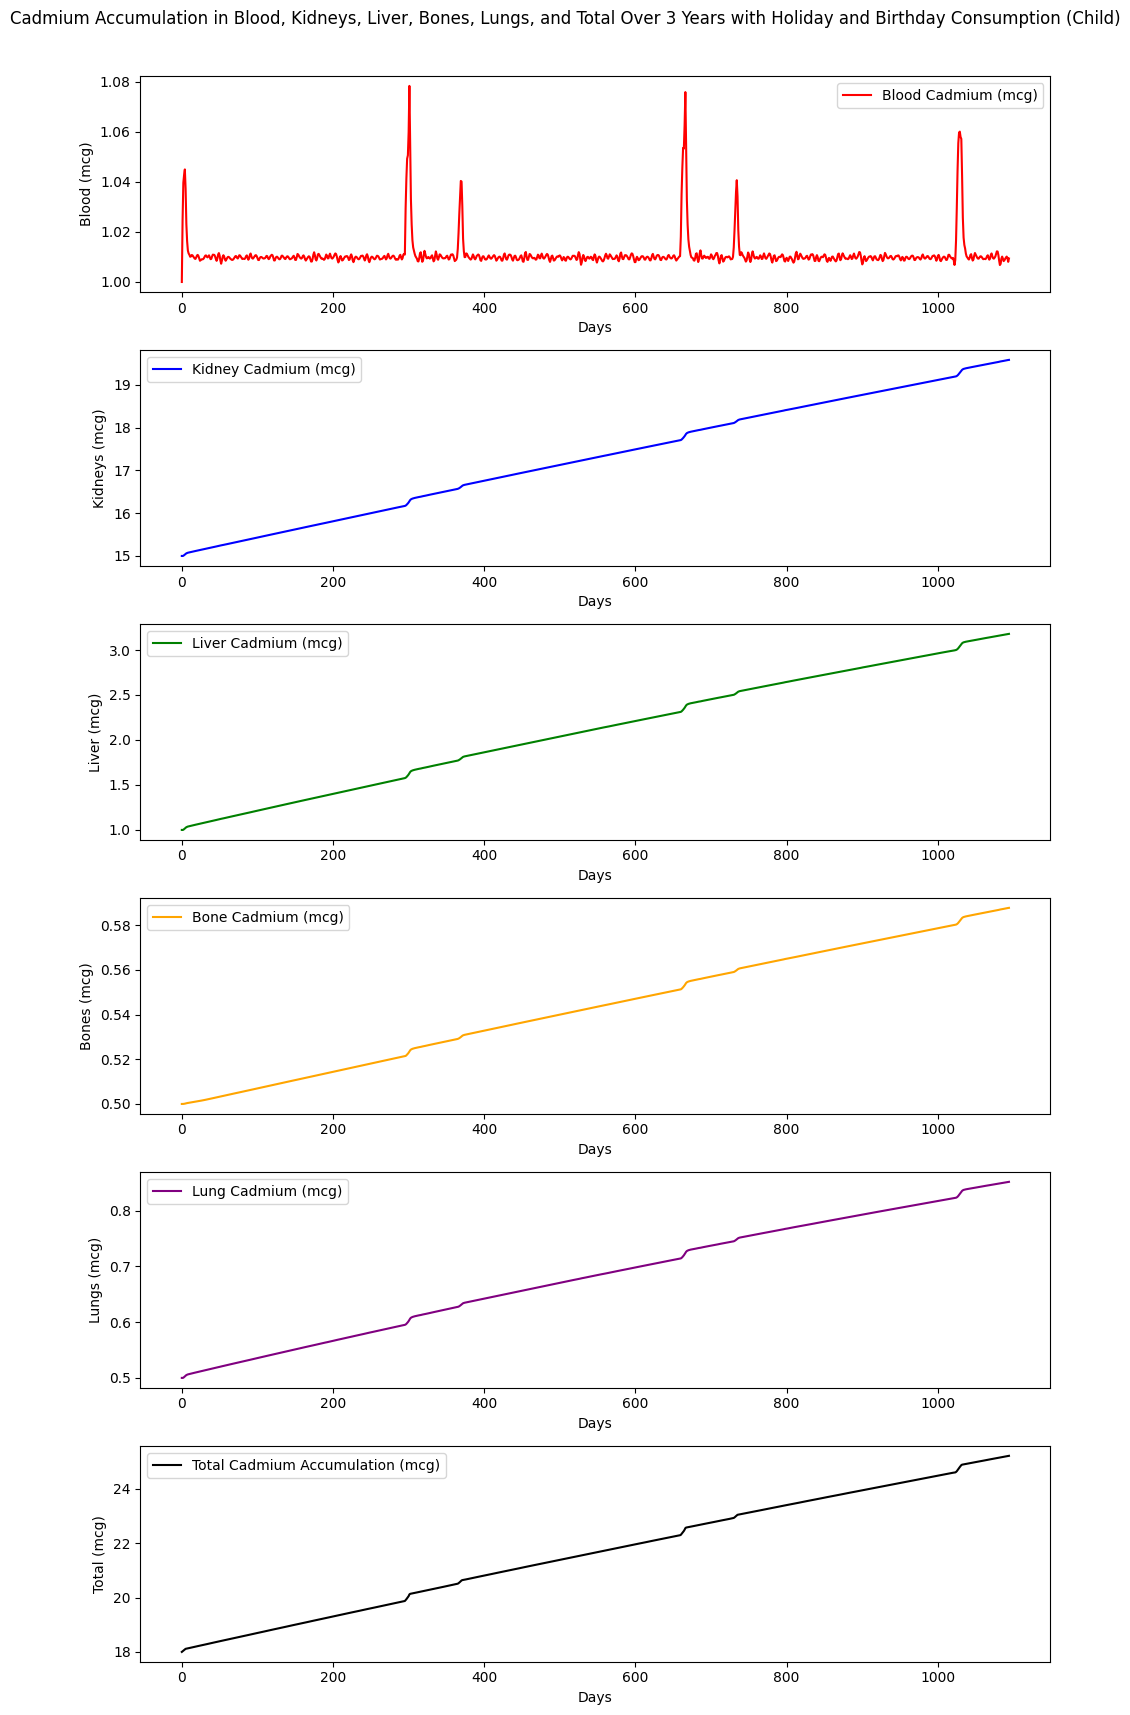

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Nutrient average intakes (mg/day) for children
Fe_avg = 8.5     # Iron
Ca_avg = 900     # Calcium
Zn_avg = 6.5     # Zinc

# Nutrient modulation coefficients
k_Fe = 0.12
k_Ca = 0.06
k_Zn = 0.08

# Baseline cadmium levels (micrograms) in minimally exposed children
baseline_kidneys = 15
baseline_liver = 1
baseline_bones = 0.5
baseline_lungs = 0.5
baseline_blood = 1

# Time-varying functions for Fe, Ca, and Zn levels with weekly fluctuations
def Fe_level(t):
    return Fe_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Ca_level(t):
    return Ca_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Zn_level(t):
    return Zn_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

# Daily cadmium intake for children with increased intake during holidays and birthday
def baseline_intake(t):
    # Regular daily intake
    daily_intake = 4.358  # mcg/day from daily chocolate consumption

    # Holiday intake: 10x the daily intake for 5 days starting at day 0 each year
    holiday_intake = 3 * daily_intake if (t % 365 < 5) else 0

    # Birthday intake: 10x the daily intake for 1 day, starting at day 300 each year
    birthday_intake = 5 * daily_intake if (295 <= t % 365 < 301) else 0

    # Total intake is the sum of regular intake, holiday intake, and birthday intake
    return daily_intake + holiday_intake + birthday_intake

# Effective intake with nutrient modulation
def effective_intake(t):
    base = baseline_intake(t)
    modulating_factor = 1 / (1 + k_Fe * Fe_level(t) + k_Ca * Ca_level(t) + k_Zn * Zn_level(t))
    return absorption_rate * base * modulating_factor

# Parameters for cadmium intake and initial absorption for children
absorption_rate = 0.08  # Cadmium absorption rate into blood (8% for children)

# Maximum total transfer rates and alpha values based on the target timeframes
R_kidneys_liver_lungs = 0.66  # Maximum total transfer rate for kidneys, liver, and lungs (7-day target)
R_bones = 0.154               # Maximum total transfer rate for bones (30-day target)
alpha_fast = 1                # Faster approach for kidneys, liver, and lungs
alpha_slow = 0.1              # Slower approach for bones

# Time-dependent individual transfer rates as fractions of total transfer
def r_k(t):
    return 0.6 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_l(t):
    return 0.3 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_lungs(t):
    return 0.05 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_b(t):
    return 0.05 * R_bones * (1 - np.exp(-alpha_slow * (t - 1))) if t > 1 else 0

# Excretion rates calculated from half-lives (in days)
excretion_rate_kidneys = np.log(2) / 7300   # Average 20-year half-life
excretion_rate_liver = np.log(2) / 3650     # Average 10-year half-life
excretion_rate_bones = np.log(2) / 7300     # Average 20-year half-life
excretion_rate_lungs = np.log(2) / 2737.5   # Average 7.5-year half-life

# System of differential equations with baseline levels
def cadmium_dynamics(t, C):
    C_blood, C_k, C_l, C_b, C_lungs = C
    intake = effective_intake(t)

    # Blood compartment: gradual transfer to organs after day 1, maintaining baseline
    if t <= 1:
        dCblood_dt = intake
    else:
        dCblood_dt = intake - (r_k(t) + r_l(t) + r_b(t) + r_lungs(t)) * (C_blood - baseline_blood)

    # Organ compartments: start accumulating after day 1, with excretion once accumulation begins
    dCk_dt = r_k(t) * (C_blood - baseline_blood) - excretion_rate_kidneys * (C_k - baseline_kidneys)
    dCl_dt = r_l(t) * (C_blood - baseline_blood) - excretion_rate_liver * (C_l - baseline_liver)
    dCb_dt = r_b(t) * (C_blood - baseline_blood) - excretion_rate_bones * (C_b - baseline_bones)
    dClungs_dt = r_lungs(t) * (C_blood - baseline_blood) - excretion_rate_lungs * (C_lungs - baseline_lungs)

    return [dCblood_dt, dCk_dt, dCl_dt, dCb_dt, dClungs_dt]

# Time span for simulation (3 years in days)
time_span = (0, 3 * 365)  # 3 years in days
initial_conditions = [baseline_blood, baseline_kidneys, baseline_liver, baseline_bones, baseline_lungs]

# Solving the system with daily evaluation intervals
solution = solve_ivp(cadmium_dynamics, time_span, initial_conditions, method='RK45', t_eval=np.arange(0, 3 * 365, 1))

# Calculate total cadmium accumulation as the sum of all organs and blood
total_cadmium = solution.y[0] + solution.y[1] + solution.y[2] + solution.y[3] + solution.y[4]

# Plotting each cadmium accumulation in a separate graph without shared x-axis
fig, axes = plt.subplots(6, 1, figsize=(10, 18))

axes[0].plot(solution.t, solution.y[0], label="Blood Cadmium (mcg)", color="red")
axes[0].set_ylabel("Blood (mcg)")
axes[0].legend()
axes[0].set_xlabel("Days")

axes[1].plot(solution.t, solution.y[1], label="Kidney Cadmium (mcg)", color="blue")
axes[1].set_ylabel("Kidneys (mcg)")
axes[1].legend()
axes[1].set_xlabel("Days")

axes[2].plot(solution.t, solution.y[2], label="Liver Cadmium (mcg)", color="green")
axes[2].set_ylabel("Liver (mcg)")
axes[2].legend()
axes[2].set_xlabel("Days")

axes[3].plot(solution.t, solution.y[3], label="Bone Cadmium (mcg)", color="orange")
axes[3].set_ylabel("Bones (mcg)")
axes[3].legend()
axes[3].set_xlabel("Days")

axes[4].plot(solution.t, solution.y[4], label="Lung Cadmium (mcg)", color="purple")
axes[4].set_ylabel("Lungs (mcg)")
axes[4].legend()
axes[4].set_xlabel("Days")

axes[5].plot(solution.t, total_cadmium, label="Total Cadmium Accumulation (mcg)", color="black")
axes[5].set_ylabel("Total (mcg)")
axes[5].set_xlabel("Days")
axes[5].legend()

fig.suptitle("Cadmium Accumulation in Blood, Kidneys, Liver, Bones, Lungs, and Total Over 3 Years with Holiday and Birthday Consumption (Child)")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# Sinh nhật (x5) gần lễ (x3)

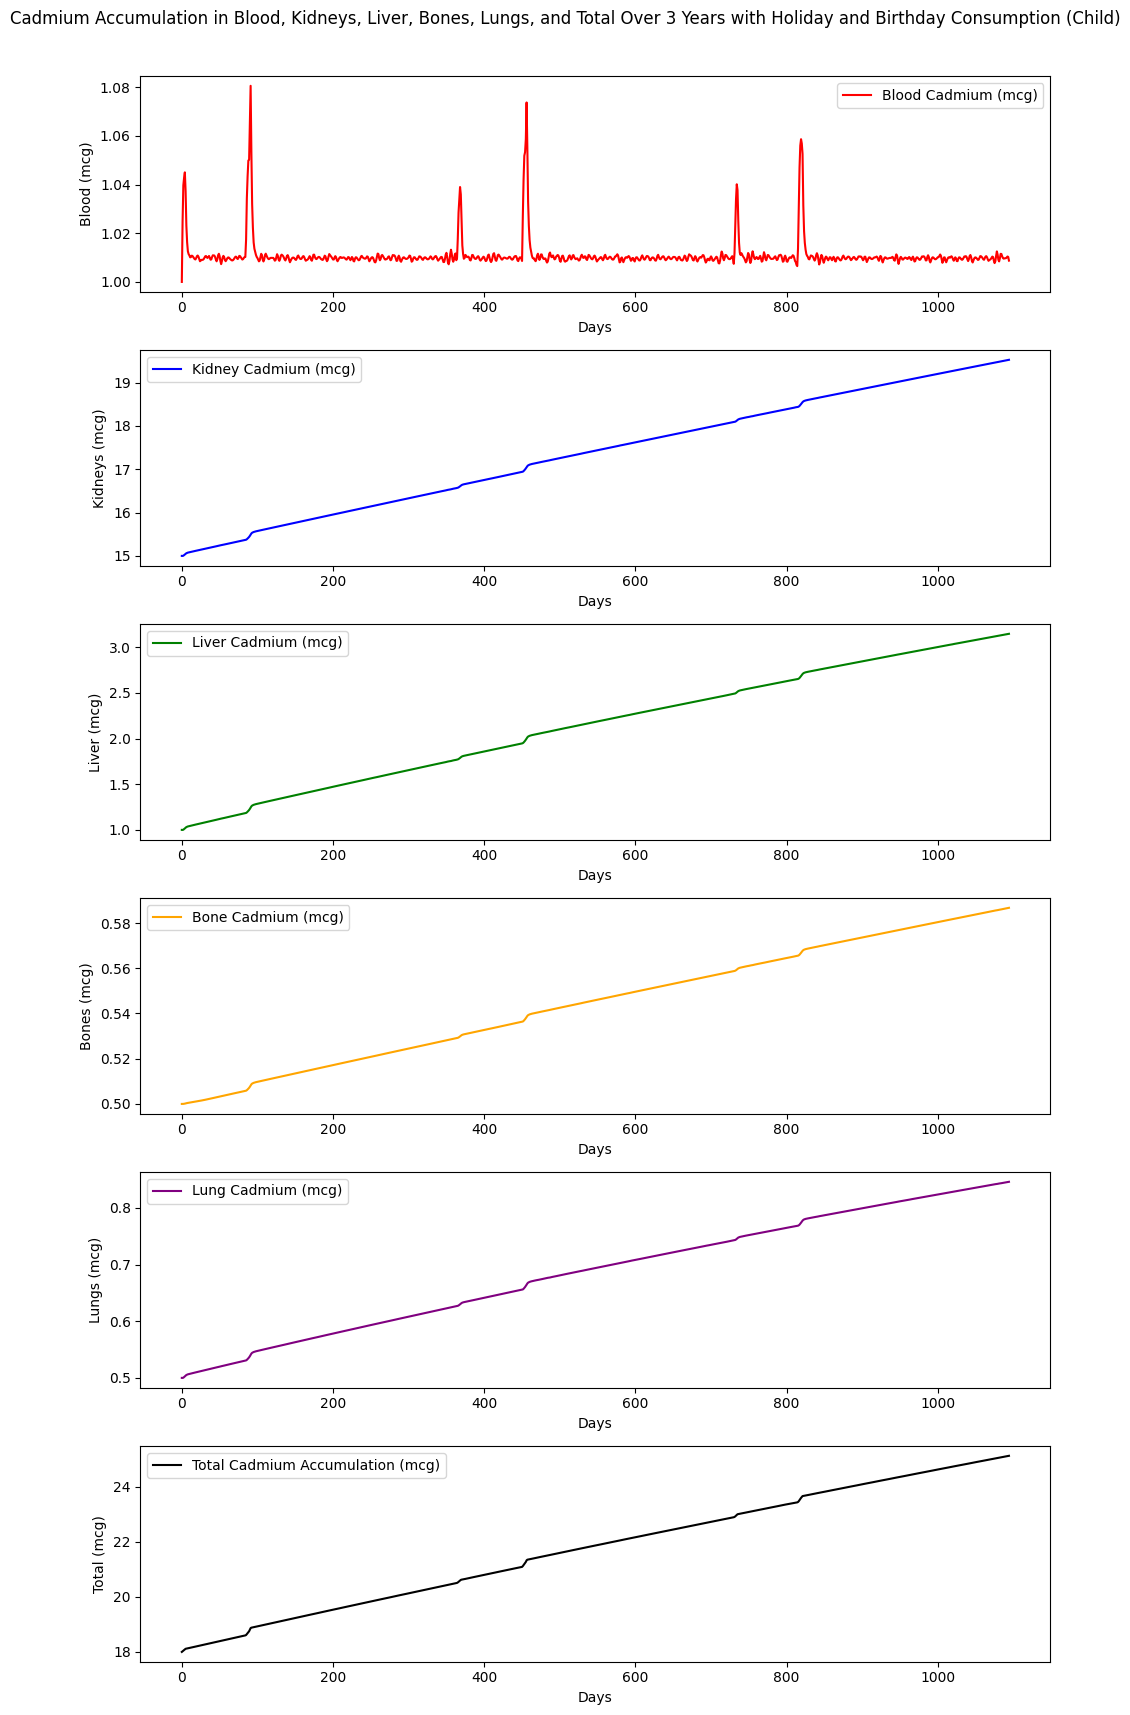

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Nutrient average intakes (mg/day) for children
Fe_avg = 8.5     # Iron
Ca_avg = 900     # Calcium
Zn_avg = 6.5     # Zinc

# Nutrient modulation coefficients
k_Fe = 0.12
k_Ca = 0.06
k_Zn = 0.08

# Baseline cadmium levels (micrograms) in minimally exposed children
baseline_kidneys = 15
baseline_liver = 1
baseline_bones = 0.5
baseline_lungs = 0.5
baseline_blood = 1

# Time-varying functions for Fe, Ca, and Zn levels with weekly fluctuations
def Fe_level(t):
    return Fe_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Ca_level(t):
    return Ca_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Zn_level(t):
    return Zn_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

# Daily cadmium intake for children with increased intake during holidays and birthday
def baseline_intake(t):
    # Regular daily intake
    daily_intake = 4.358  # mcg/day from daily chocolate consumption

    # Holiday intake: 10x the daily intake for 5 days starting at day 0 each year
    holiday_intake = 3 * daily_intake if (t % 365 < 5) else 0

    # Birthday intake: 10x the daily intake for 1 day, occurring 90 days after holiday each year
    birthday_intake = 5 * daily_intake if (85 <= t % 365 < 91) else 0

    # Total intake is the sum of regular intake, holiday intake, and birthday intake
    return daily_intake + holiday_intake + birthday_intake

# Effective intake with nutrient modulation
def effective_intake(t):
    base = baseline_intake(t)
    modulating_factor = 1 / (1 + k_Fe * Fe_level(t) + k_Ca * Ca_level(t) + k_Zn * Zn_level(t))
    return absorption_rate * base * modulating_factor

# Parameters for cadmium intake and initial absorption for children
absorption_rate = 0.08  # Cadmium absorption rate into blood (8% for children)

# Maximum total transfer rates and alpha values based on the target timeframes
R_kidneys_liver_lungs = 0.66  # Maximum total transfer rate for kidneys, liver, and lungs (7-day target)
R_bones = 0.154               # Maximum total transfer rate for bones (30-day target)
alpha_fast = 1                # Faster approach for kidneys, liver, and lungs
alpha_slow = 0.1              # Slower approach for bones

# Time-dependent individual transfer rates as fractions of total transfer
def r_k(t):
    return 0.6 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_l(t):
    return 0.3 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_lungs(t):
    return 0.05 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_b(t):
    return 0.05 * R_bones * (1 - np.exp(-alpha_slow * (t - 1))) if t > 1 else 0

# Excretion rates calculated from half-lives (in days)
excretion_rate_kidneys = np.log(2) / 7300   # Average 20-year half-life
excretion_rate_liver = np.log(2) / 3650     # Average 10-year half-life
excretion_rate_bones = np.log(2) / 7300     # Average 20-year half-life
excretion_rate_lungs = np.log(2) / 2737.5   # Average 7.5-year half-life

# System of differential equations with baseline levels
def cadmium_dynamics(t, C):
    C_blood, C_k, C_l, C_b, C_lungs = C
    intake = effective_intake(t)

    # Blood compartment: gradual transfer to organs after day 1, maintaining baseline
    if t <= 1:
        dCblood_dt = intake
    else:
        dCblood_dt = intake - (r_k(t) + r_l(t) + r_b(t) + r_lungs(t)) * (C_blood - baseline_blood)

    # Organ compartments: start accumulating after day 1, with excretion once accumulation begins
    dCk_dt = r_k(t) * (C_blood - baseline_blood) - excretion_rate_kidneys * (C_k - baseline_kidneys)
    dCl_dt = r_l(t) * (C_blood - baseline_blood) - excretion_rate_liver * (C_l - baseline_liver)
    dCb_dt = r_b(t) * (C_blood - baseline_blood) - excretion_rate_bones * (C_b - baseline_bones)
    dClungs_dt = r_lungs(t) * (C_blood - baseline_blood) - excretion_rate_lungs * (C_lungs - baseline_lungs)

    return [dCblood_dt, dCk_dt, dCl_dt, dCb_dt, dClungs_dt]

# Time span for simulation (3 years in days)
time_span = (0, 3 * 365)  # 3 years in days
initial_conditions = [baseline_blood, baseline_kidneys, baseline_liver, baseline_bones, baseline_lungs]

# Solving the system with daily evaluation intervals
solution = solve_ivp(cadmium_dynamics, time_span, initial_conditions, method='RK45', t_eval=np.arange(0, 3 * 365, 1))

# Calculate total cadmium accumulation as the sum of all organs and blood
total_cadmium = solution.y[0] + solution.y[1] + solution.y[2] + solution.y[3] + solution.y[4]

# Plotting each cadmium accumulation in a separate graph without shared x-axis
fig, axes = plt.subplots(6, 1, figsize=(10, 18))

axes[0].plot(solution.t, solution.y[0], label="Blood Cadmium (mcg)", color="red")
axes[0].set_ylabel("Blood (mcg)")
axes[0].legend()
axes[0].set_xlabel("Days")

axes[1].plot(solution.t, solution.y[1], label="Kidney Cadmium (mcg)", color="blue")
axes[1].set_ylabel("Kidneys (mcg)")
axes[1].legend()
axes[1].set_xlabel("Days")

axes[2].plot(solution.t, solution.y[2], label="Liver Cadmium (mcg)", color="green")
axes[2].set_ylabel("Liver (mcg)")
axes[2].legend()
axes[2].set_xlabel("Days")

axes[3].plot(solution.t, solution.y[3], label="Bone Cadmium (mcg)", color="orange")
axes[3].set_ylabel("Bones (mcg)")
axes[3].legend()
axes[3].set_xlabel("Days")

axes[4].plot(solution.t, solution.y[4], label="Lung Cadmium (mcg)", color="purple")
axes[4].set_ylabel("Lungs (mcg)")
axes[4].legend()
axes[4].set_xlabel("Days")

axes[5].plot(solution.t, total_cadmium, label="Total Cadmium Accumulation (mcg)", color="black")
axes[5].set_ylabel("Total (mcg)")
axes[5].set_xlabel("Days")
axes[5].legend()

fig.suptitle("Cadmium Accumulation in Blood, Kidneys, Liver, Bones, Lungs, and Total Over 3 Years with Holiday and Birthday Consumption (Child)")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# Sinh nhật gần lễ 3 năm xong không ăn nữa

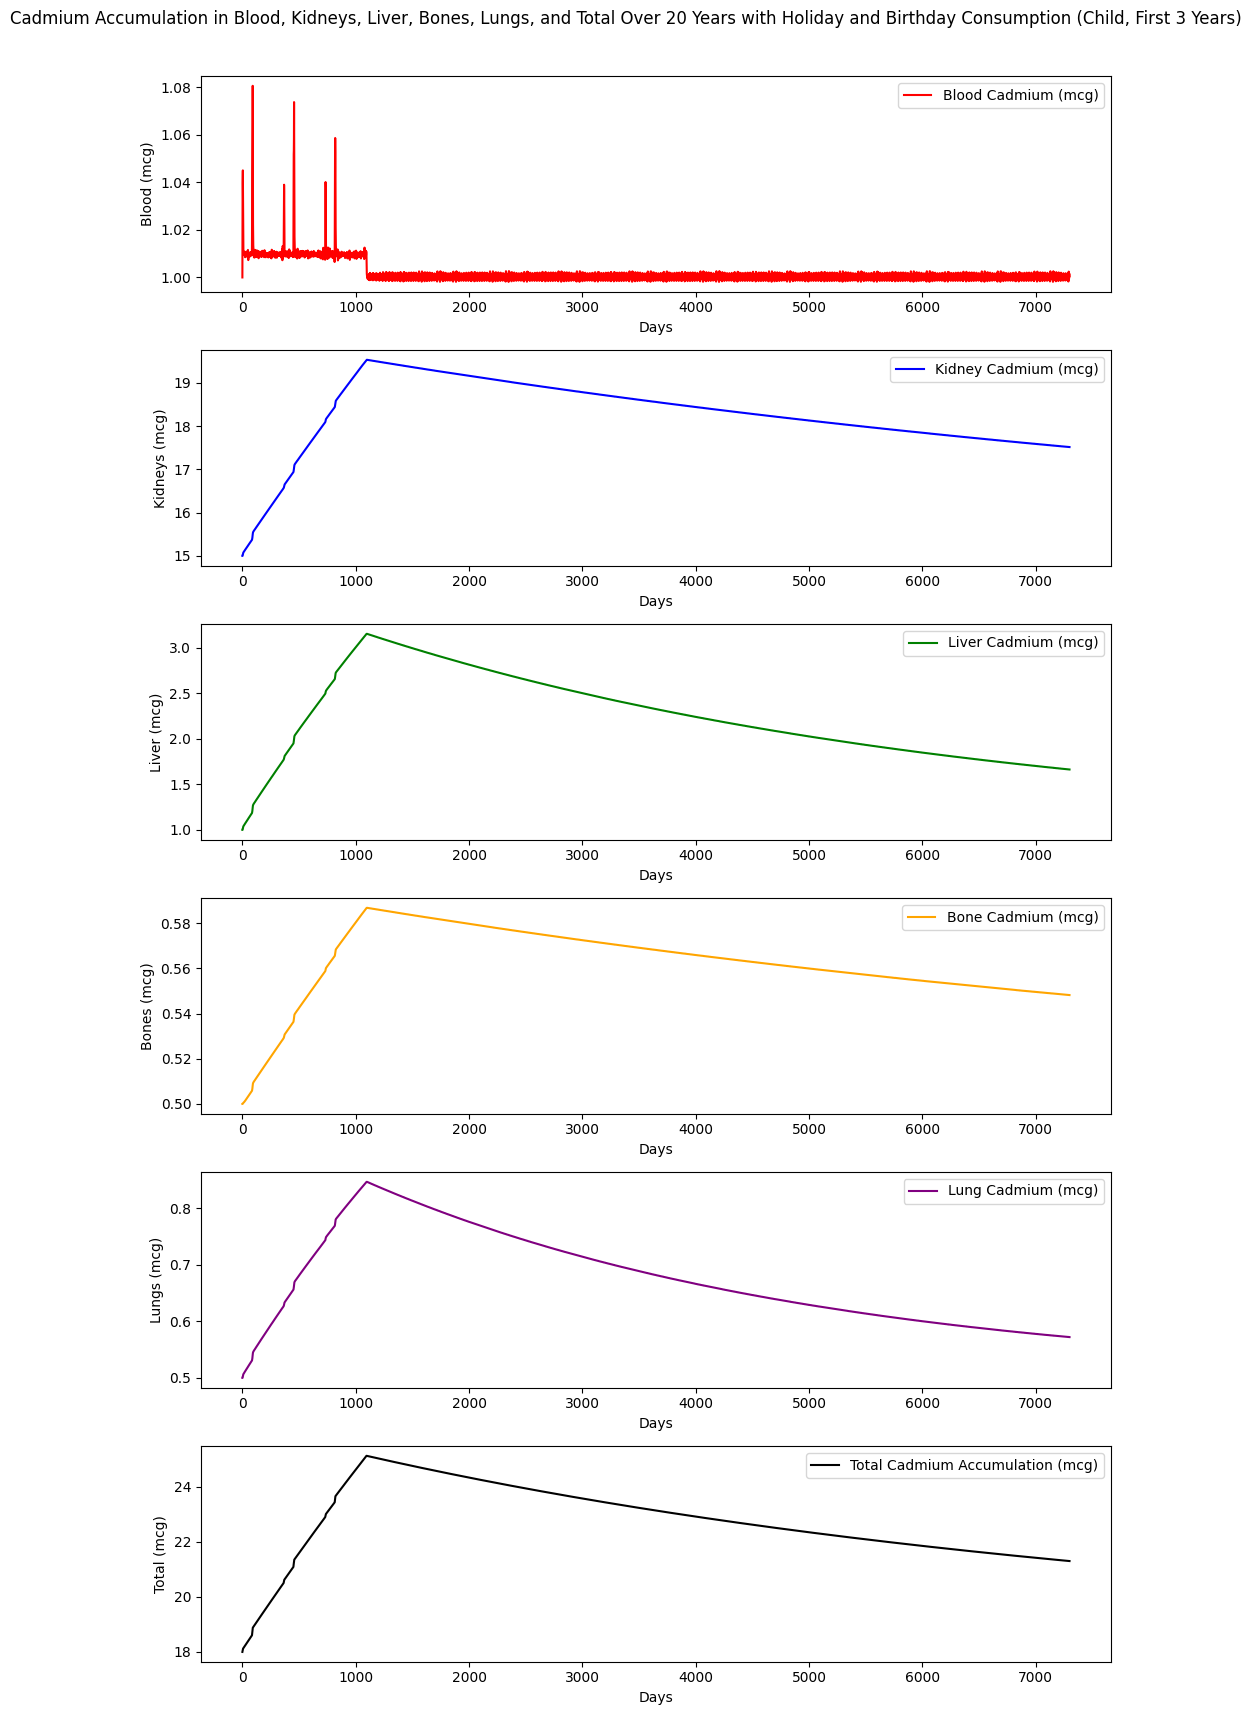

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Nutrient average intakes (mg/day) for children
Fe_avg = 8.5     # Iron
Ca_avg = 900     # Calcium
Zn_avg = 6.5     # Zinc

# Nutrient modulation coefficients
k_Fe = 0.12
k_Ca = 0.06
k_Zn = 0.08

# Baseline cadmium levels (micrograms) in minimally exposed children
baseline_kidneys = 15
baseline_liver = 1
baseline_bones = 0.5
baseline_lungs = 0.5
baseline_blood = 1

# Time-varying functions for Fe, Ca, and Zn levels with weekly fluctuations
def Fe_level(t):
    return Fe_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Ca_level(t):
    return Ca_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Zn_level(t):
    return Zn_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

# Daily cadmium intake for children with increased intake during holidays and birthday
def baseline_intake(t):
    # Regular daily intake for the first 3 years only
    if t < 3 * 365:
        daily_intake = 4.358  # mcg/day from daily chocolate consumption
        # Holiday intake: 10x the daily intake for 5 days at the beginning of each year
        holiday_intake = 3 * daily_intake if (t % 365 < 5) else 0
        # Birthday intake: 10x the daily intake for 1 day, 90 days after the holiday
        birthday_intake = 5 * daily_intake if (85 <= t % 365 < 91) else 0
        # Total intake is the sum of regular intake, holiday intake, and birthday intake
        return daily_intake + holiday_intake + birthday_intake
    else:
        return 0  # No intake after the first 3 years

# Effective intake with nutrient modulation
def effective_intake(t):
    base = baseline_intake(t)
    modulating_factor = 1 / (1 + k_Fe * Fe_level(t) + k_Ca * Ca_level(t) + k_Zn * Zn_level(t))
    return absorption_rate * base * modulating_factor

# Parameters for cadmium intake and initial absorption for children
absorption_rate = 0.08  # Cadmium absorption rate into blood (8% for children)

# Maximum total transfer rates and alpha values based on the target timeframes
R_kidneys_liver_lungs = 0.66  # Maximum total transfer rate for kidneys, liver, and lungs (7-day target)
R_bones = 0.154               # Maximum total transfer rate for bones (30-day target)
alpha_fast = 1                # Faster approach for kidneys, liver, and lungs
alpha_slow = 0.1              # Slower approach for bones

# Time-dependent individual transfer rates as fractions of total transfer
def r_k(t):
    return 0.6 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_l(t):
    return 0.3 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_lungs(t):
    return 0.05 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_b(t):
    return 0.05 * R_bones * (1 - np.exp(-alpha_slow * (t - 1))) if t > 1 else 0

# Excretion rates calculated from half-lives (in days)
excretion_rate_kidneys = np.log(2) / 7300   # Average 20-year half-life
excretion_rate_liver = np.log(2) / 3650     # Average 10-year half-life
excretion_rate_bones = np.log(2) / 7300     # Average 20-year half-life
excretion_rate_lungs = np.log(2) / 2737.5   # Average 7.5-year half-life

# System of differential equations with baseline levels
def cadmium_dynamics(t, C):
    C_blood, C_k, C_l, C_b, C_lungs = C
    intake = effective_intake(t)

    # Blood compartment: gradual transfer to organs after day 1, maintaining baseline
    if t <= 1:
        dCblood_dt = intake
    else:
        dCblood_dt = intake - (r_k(t) + r_l(t) + r_b(t) + r_lungs(t)) * (C_blood - baseline_blood)

    # Organ compartments: start accumulating after day 1, with excretion once accumulation begins
    dCk_dt = r_k(t) * (C_blood - baseline_blood) - excretion_rate_kidneys * (C_k - baseline_kidneys)
    dCl_dt = r_l(t) * (C_blood - baseline_blood) - excretion_rate_liver * (C_l - baseline_liver)
    dCb_dt = r_b(t) * (C_blood - baseline_blood) - excretion_rate_bones * (C_b - baseline_bones)
    dClungs_dt = r_lungs(t) * (C_blood - baseline_blood) - excretion_rate_lungs * (C_lungs - baseline_lungs)

    return [dCblood_dt, dCk_dt, dCl_dt, dCb_dt, dClungs_dt]

# Time span for simulation (20 years in days)
time_span = (0, 20 * 365)  # 20 years in days
initial_conditions = [baseline_blood, baseline_kidneys, baseline_liver, baseline_bones, baseline_lungs]

# Solving the system with daily evaluation intervals
solution = solve_ivp(cadmium_dynamics, time_span, initial_conditions, method='RK45', t_eval=np.arange(0, 20 * 365, 1))

# Calculate total cadmium accumulation as the sum of all organs and blood
total_cadmium = solution.y[0] + solution.y[1] + solution.y[2] + solution.y[3] + solution.y[4]

# Plotting each cadmium accumulation in a separate graph without shared x-axis
fig, axes = plt.subplots(6, 1, figsize=(10, 18))

axes[0].plot(solution.t, solution.y[0], label="Blood Cadmium (mcg)", color="red")
axes[0].set_ylabel("Blood (mcg)")
axes[0].legend()
axes[0].set_xlabel("Days")

axes[1].plot(solution.t, solution.y[1], label="Kidney Cadmium (mcg)", color="blue")
axes[1].set_ylabel("Kidneys (mcg)")
axes[1].legend()
axes[1].set_xlabel("Days")

axes[2].plot(solution.t, solution.y[2], label="Liver Cadmium (mcg)", color="green")
axes[2].set_ylabel("Liver (mcg)")
axes[2].legend()
axes[2].set_xlabel("Days")

axes[3].plot(solution.t, solution.y[3], label="Bone Cadmium (mcg)", color="orange")
axes[3].set_ylabel("Bones (mcg)")
axes[3].legend()
axes[3].set_xlabel("Days")

axes[4].plot(solution.t, solution.y[4], label="Lung Cadmium (mcg)", color="purple")
axes[4].set_ylabel("Lungs (mcg)")
axes[4].legend()
axes[4].set_xlabel("Days")

axes[5].plot(solution.t, total_cadmium, label="Total Cadmium Accumulation (mcg)", color="black")
axes[5].set_ylabel("Total (mcg)")
axes[5].set_xlabel("Days")
axes[5].legend()

fig.suptitle("Cadmium Accumulation in Blood, Kidneys, Liver, Bones, Lungs, and Total Over 20 Years with Holiday and Birthday Consumption (Child, First 3 Years)")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# Sinh nhật xa lễ ăn 3 năm không ăn nữa

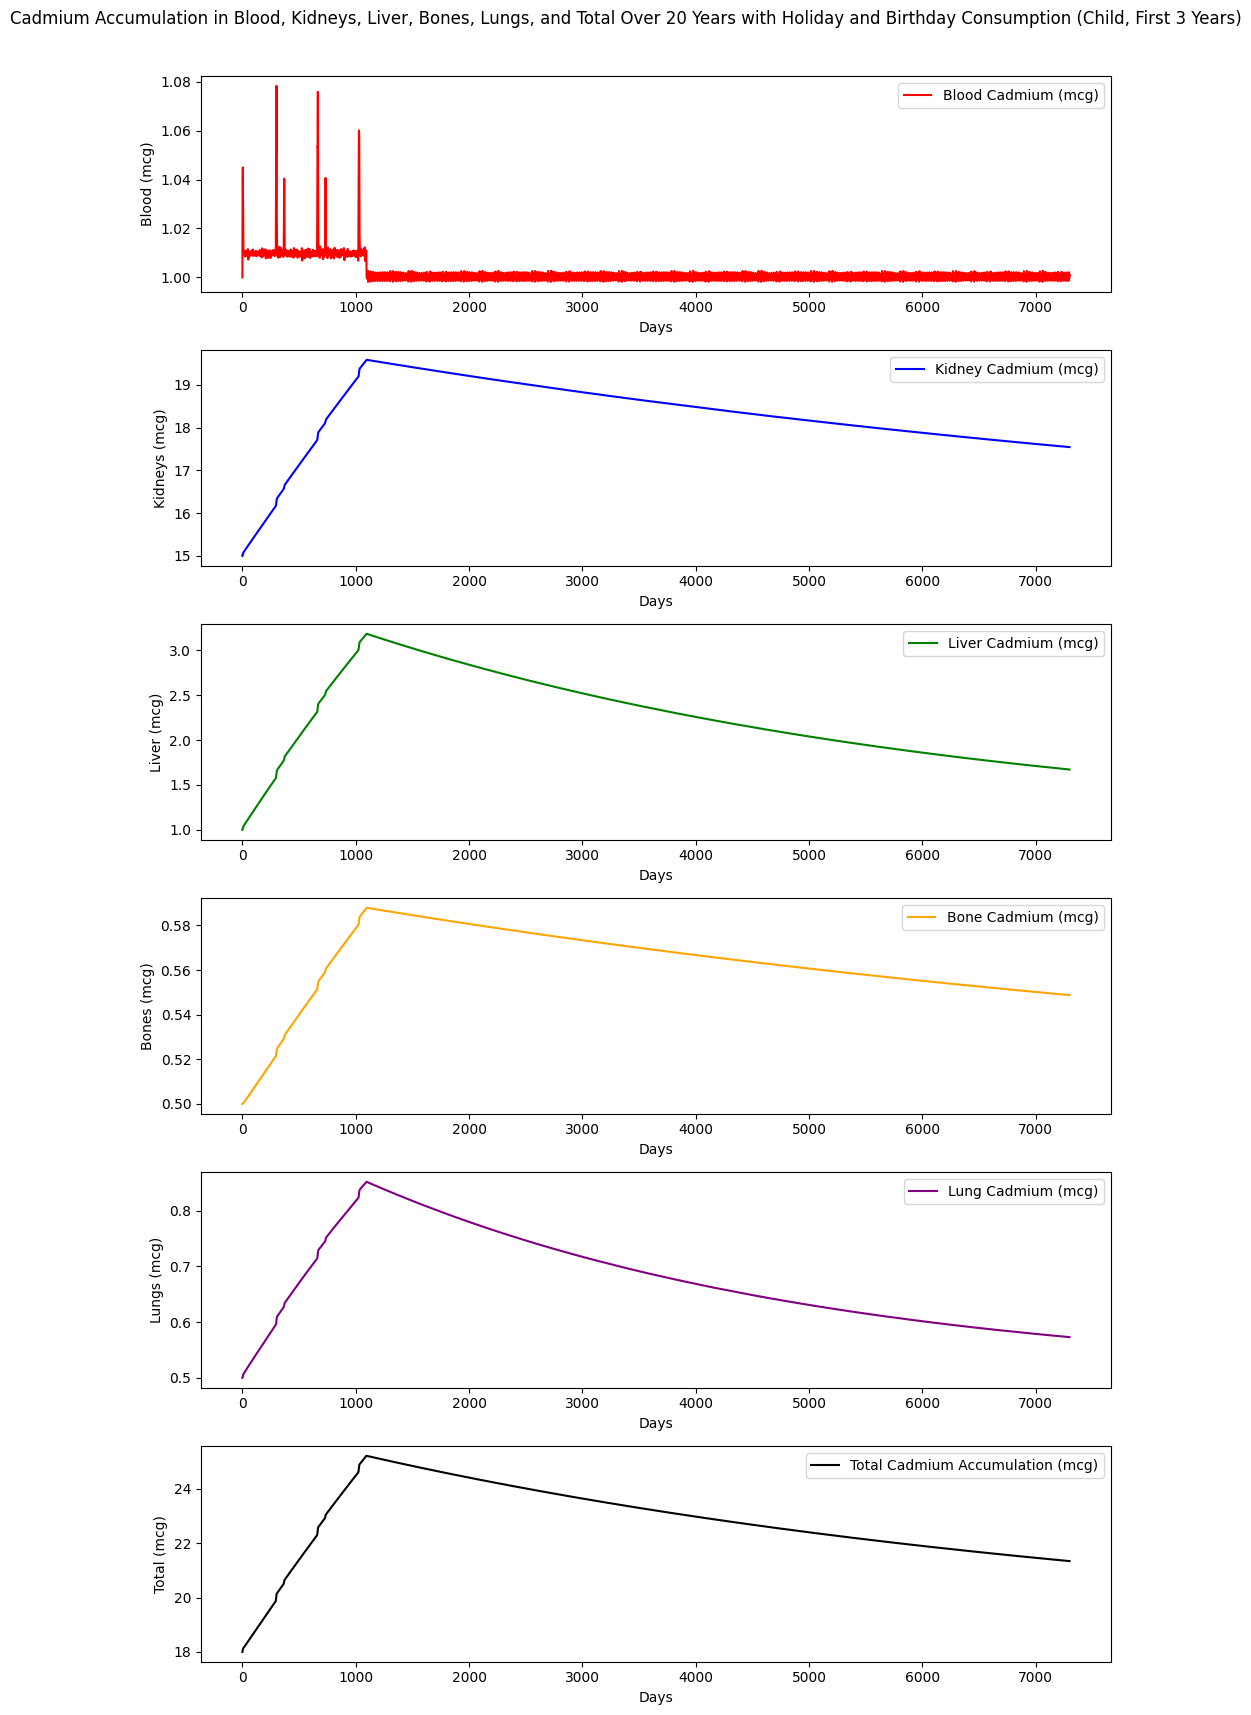

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Nutrient average intakes (mg/day) for children
Fe_avg = 8.5     # Iron
Ca_avg = 900     # Calcium
Zn_avg = 6.5     # Zinc

# Nutrient modulation coefficients
k_Fe = 0.12
k_Ca = 0.06
k_Zn = 0.08

# Baseline cadmium levels (micrograms) in minimally exposed children
baseline_kidneys = 15
baseline_liver = 1
baseline_bones = 0.5
baseline_lungs = 0.5
baseline_blood = 1

# Time-varying functions for Fe, Ca, and Zn levels with weekly fluctuations
def Fe_level(t):
    return Fe_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Ca_level(t):
    return Ca_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Zn_level(t):
    return Zn_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

# Daily cadmium intake for children with increased intake during holidays and birthday
def baseline_intake(t):
    # Regular daily intake for the first 3 years only
    if t < 3 * 365:
        daily_intake = 4.358  # mcg/day from daily chocolate consumption

        # Holiday intake: 3x the daily intake for 5 days at the beginning of each year
        holiday_intake = 3 * daily_intake if (t % 365 < 5) else 0

        # Birthday intake: 5x the daily intake for 1 day, 300 days after the holiday
        birthday_intake = 5 * daily_intake if (295 <= t % 365 < 301) else 0

        # Total intake is the sum of regular intake, holiday intake, and birthday intake
        return daily_intake + holiday_intake + birthday_intake
    else:
        return 0  # No intake after the first 3 years

# Effective intake with nutrient modulation
def effective_intake(t):
    base = baseline_intake(t)
    modulating_factor = 1 / (1 + k_Fe * Fe_level(t) + k_Ca * Ca_level(t) + k_Zn * Zn_level(t))
    return absorption_rate * base * modulating_factor

# Parameters for cadmium intake and initial absorption for children
absorption_rate = 0.08  # Cadmium absorption rate into blood (8% for children)

# Maximum total transfer rates and alpha values based on the target timeframes
R_kidneys_liver_lungs = 0.66  # Maximum total transfer rate for kidneys, liver, and lungs (7-day target)
R_bones = 0.154               # Maximum total transfer rate for bones (30-day target)
alpha_fast = 1                # Faster approach for kidneys, liver, and lungs
alpha_slow = 0.1              # Slower approach for bones

# Time-dependent individual transfer rates as fractions of total transfer
def r_k(t):
    return 0.6 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_l(t):
    return 0.3 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_lungs(t):
    return 0.05 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_b(t):
    return 0.05 * R_bones * (1 - np.exp(-alpha_slow * (t - 1))) if t > 1 else 0

# Excretion rates calculated from half-lives (in days)
excretion_rate_kidneys = np.log(2) / 7300   # Average 20-year half-life
excretion_rate_liver = np.log(2) / 3650     # Average 10-year half-life
excretion_rate_bones = np.log(2) / 7300     # Average 20-year half-life
excretion_rate_lungs = np.log(2) / 2737.5   # Average 7.5-year half-life

# System of differential equations with baseline levels
def cadmium_dynamics(t, C):
    C_blood, C_k, C_l, C_b, C_lungs = C
    intake = effective_intake(t)

    # Blood compartment: gradual transfer to organs after day 1, maintaining baseline
    if t <= 1:
        dCblood_dt = intake
    else:
        dCblood_dt = intake - (r_k(t) + r_l(t) + r_b(t) + r_lungs(t)) * (C_blood - baseline_blood)

    # Organ compartments: start accumulating after day 1, with excretion once accumulation begins
    dCk_dt = r_k(t) * (C_blood - baseline_blood) - excretion_rate_kidneys * (C_k - baseline_kidneys)
    dCl_dt = r_l(t) * (C_blood - baseline_blood) - excretion_rate_liver * (C_l - baseline_liver)
    dCb_dt = r_b(t) * (C_blood - baseline_blood) - excretion_rate_bones * (C_b - baseline_bones)
    dClungs_dt = r_lungs(t) * (C_blood - baseline_blood) - excretion_rate_lungs * (C_lungs - baseline_lungs)

    return [dCblood_dt, dCk_dt, dCl_dt, dCb_dt, dClungs_dt]

# Time span for simulation (20 years in days)
time_span = (0, 20 * 365)  # 20 years in days
initial_conditions = [baseline_blood, baseline_kidneys, baseline_liver, baseline_bones, baseline_lungs]

# Solving the system with daily evaluation intervals
solution = solve_ivp(cadmium_dynamics, time_span, initial_conditions, method='RK45', t_eval=np.arange(0, 20 * 365, 1))

# Calculate total cadmium accumulation as the sum of all organs and blood
total_cadmium = solution.y[0] + solution.y[1] + solution.y[2] + solution.y[3] + solution.y[4]

# Plotting each cadmium accumulation in a separate graph without shared x-axis
fig, axes = plt.subplots(6, 1, figsize=(10, 18))

axes[0].plot(solution.t, solution.y[0], label="Blood Cadmium (mcg)", color="red")
axes[0].set_ylabel("Blood (mcg)")
axes[0].legend()
axes[0].set_xlabel("Days")

axes[1].plot(solution.t, solution.y[1], label="Kidney Cadmium (mcg)", color="blue")
axes[1].set_ylabel("Kidneys (mcg)")
axes[1].legend()
axes[1].set_xlabel("Days")

axes[2].plot(solution.t, solution.y[2], label="Liver Cadmium (mcg)", color="green")
axes[2].set_ylabel("Liver (mcg)")
axes[2].legend()
axes[2].set_xlabel("Days")

axes[3].plot(solution.t, solution.y[3], label="Bone Cadmium (mcg)", color="orange")
axes[3].set_ylabel("Bones (mcg)")
axes[3].legend()
axes[3].set_xlabel("Days")

axes[4].plot(solution.t, solution.y[4], label="Lung Cadmium (mcg)", color="purple")
axes[4].set_ylabel("Lungs (mcg)")
axes[4].legend()
axes[4].set_xlabel("Days")

axes[5].plot(solution.t, total_cadmium, label="Total Cadmium Accumulation (mcg)", color="black")
axes[5].set_ylabel("Total (mcg)")
axes[5].set_xlabel("Days")
axes[5].legend()

fig.suptitle("Cadmium Accumulation in Blood, Kidneys, Liver, Bones, Lungs, and Total Over 20 Years with Holiday and Birthday Consumption (Child, First 3 Years)")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# Long pẻiod after holiday

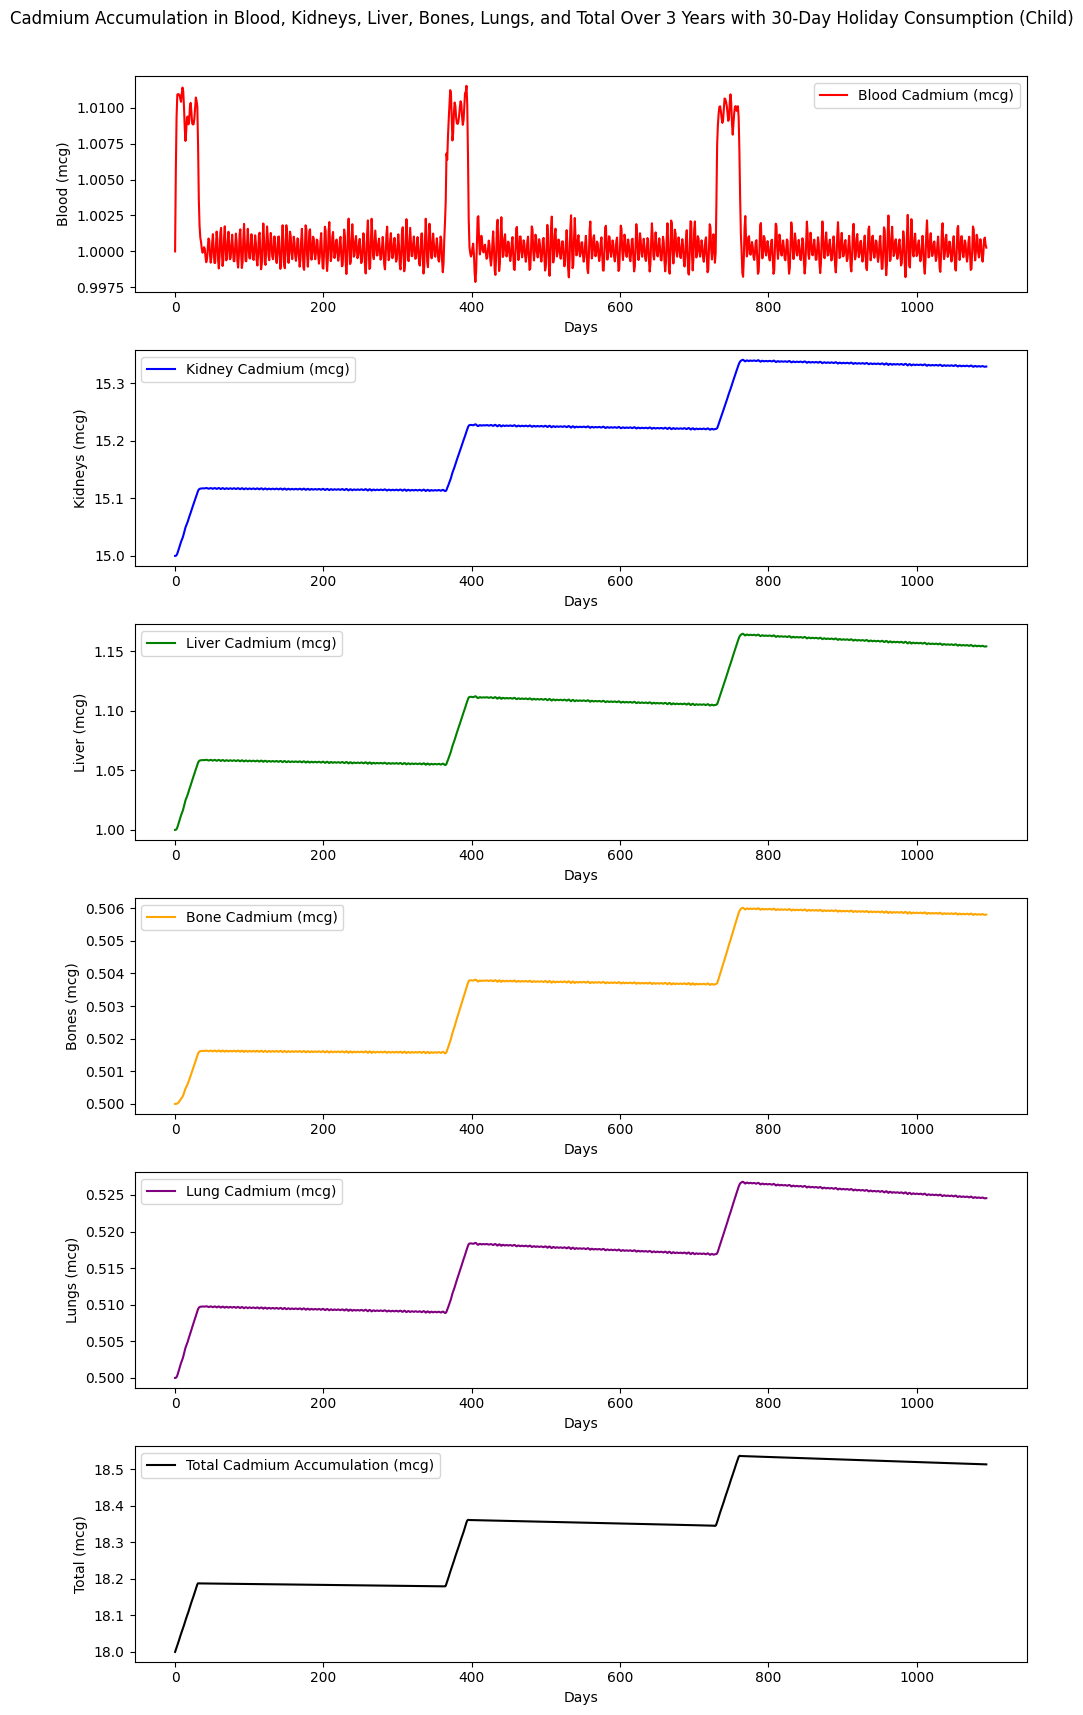

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Nutrient average intakes (mg/day) for children
Fe_avg = 8.5     # Iron
Ca_avg = 900     # Calcium
Zn_avg = 6.5     # Zinc

# Nutrient modulation coefficients
k_Fe = 0.12
k_Ca = 0.06
k_Zn = 0.08

# Baseline cadmium levels (micrograms) in minimally exposed children
baseline_kidneys = 15
baseline_liver = 1
baseline_bones = 0.5
baseline_lungs = 0.5
baseline_blood = 1

# Time-varying functions for Fe, Ca, and Zn levels with weekly fluctuations
def Fe_level(t):
    return Fe_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Ca_level(t):
    return Ca_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Zn_level(t):
    return Zn_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

# Daily cadmium intake during a 30-day holiday period each year for the first 3 years
def baseline_intake(t):
    # Intake only during a 30-day holiday period at the beginning of each year for the first 3 years
    if t < 3 * 365:
        daily_intake = 4.358  # mcg/day from daily chocolate consumption during the holiday
        holiday_intake = daily_intake if (t % 365 < 30) else 0
        return holiday_intake
    else:
        return 0  # No intake after the first 3 years

# Effective intake with nutrient modulation
def effective_intake(t):
    base = baseline_intake(t)
    modulating_factor = 1 / (1 + k_Fe * Fe_level(t) + k_Ca * Ca_level(t) + k_Zn * Zn_level(t))
    return absorption_rate * base * modulating_factor

# Parameters for cadmium intake and initial absorption for children
absorption_rate = 0.08  # Cadmium absorption rate into blood (8% for children)

# Maximum total transfer rates and alpha values based on the target timeframes
R_kidneys_liver_lungs = 0.66  # Maximum total transfer rate for kidneys, liver, and lungs (7-day target)
R_bones = 0.154               # Maximum total transfer rate for bones (30-day target)
alpha_fast = 1                # Faster approach for kidneys, liver, and lungs
alpha_slow = 0.1              # Slower approach for bones

# Time-dependent individual transfer rates as fractions of total transfer
def r_k(t):
    return 0.6 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_l(t):
    return 0.3 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_lungs(t):
    return 0.05 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_b(t):
    return 0.05 * R_bones * (1 - np.exp(-alpha_slow * (t - 1))) if t > 1 else 0

# Excretion rates calculated from half-lives (in days)
excretion_rate_kidneys = np.log(2) / 7300   # Average 20-year half-life
excretion_rate_liver = np.log(2) / 3650     # Average 10-year half-life
excretion_rate_bones = np.log(2) / 7300     # Average 20-year half-life
excretion_rate_lungs = np.log(2) / 2737.5   # Average 7.5-year half-life

# System of differential equations with baseline levels
def cadmium_dynamics(t, C):
    C_blood, C_k, C_l, C_b, C_lungs = C
    intake = effective_intake(t)

    # Blood compartment: gradual transfer to organs after day 1, maintaining baseline
    if t <= 1:
        dCblood_dt = intake
    else:
        dCblood_dt = intake - (r_k(t) + r_l(t) + r_b(t) + r_lungs(t)) * (C_blood - baseline_blood)

    # Organ compartments: start accumulating after day 1, with excretion once accumulation begins
    dCk_dt = r_k(t) * (C_blood - baseline_blood) - excretion_rate_kidneys * (C_k - baseline_kidneys)
    dCl_dt = r_l(t) * (C_blood - baseline_blood) - excretion_rate_liver * (C_l - baseline_liver)
    dCb_dt = r_b(t) * (C_blood - baseline_blood) - excretion_rate_bones * (C_b - baseline_bones)
    dClungs_dt = r_lungs(t) * (C_blood - baseline_blood) - excretion_rate_lungs * (C_lungs - baseline_lungs)

    return [dCblood_dt, dCk_dt, dCl_dt, dCb_dt, dClungs_dt]

# Time span for simulation (3 years in days)
time_span = (0, 3 * 365)  # 3 years in days
initial_conditions = [baseline_blood, baseline_kidneys, baseline_liver, baseline_bones, baseline_lungs]

# Solving the system with daily evaluation intervals
solution = solve_ivp(cadmium_dynamics, time_span, initial_conditions, method='RK45', t_eval=np.arange(0, 3 * 365, 1))

# Calculate total cadmium accumulation as the sum of all organs and blood
total_cadmium = solution.y[0] + solution.y[1] + solution.y[2] + solution.y[3] + solution.y[4]

# Plotting each cadmium accumulation in a separate graph without shared x-axis
fig, axes = plt.subplots(6, 1, figsize=(10, 18))

axes[0].plot(solution.t, solution.y[0], label="Blood Cadmium (mcg)", color="red")
axes[0].set_ylabel("Blood (mcg)")
axes[0].legend()
axes[0].set_xlabel("Days")

axes[1].plot(solution.t, solution.y[1], label="Kidney Cadmium (mcg)", color="blue")
axes[1].set_ylabel("Kidneys (mcg)")
axes[1].legend()
axes[1].set_xlabel("Days")

axes[2].plot(solution.t, solution.y[2], label="Liver Cadmium (mcg)", color="green")
axes[2].set_ylabel("Liver (mcg)")
axes[2].legend()
axes[2].set_xlabel("Days")

axes[3].plot(solution.t, solution.y[3], label="Bone Cadmium (mcg)", color="orange")
axes[3].set_ylabel("Bones (mcg)")
axes[3].legend()
axes[3].set_xlabel("Days")

axes[4].plot(solution.t, solution.y[4], label="Lung Cadmium (mcg)", color="purple")
axes[4].set_ylabel("Lungs (mcg)")
axes[4].legend()
axes[4].set_xlabel("Days")

axes[5].plot(solution.t, total_cadmium, label="Total Cadmium Accumulation (mcg)", color="black")
axes[5].set_ylabel("Total (mcg)")
axes[5].set_xlabel("Days")
axes[5].legend()

fig.suptitle("Cadmium Accumulation in Blood, Kidneys, Liver, Bones, Lungs, and Total Over 3 Years with 30-Day Holiday Consumption (Child)")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# Long period after holiday

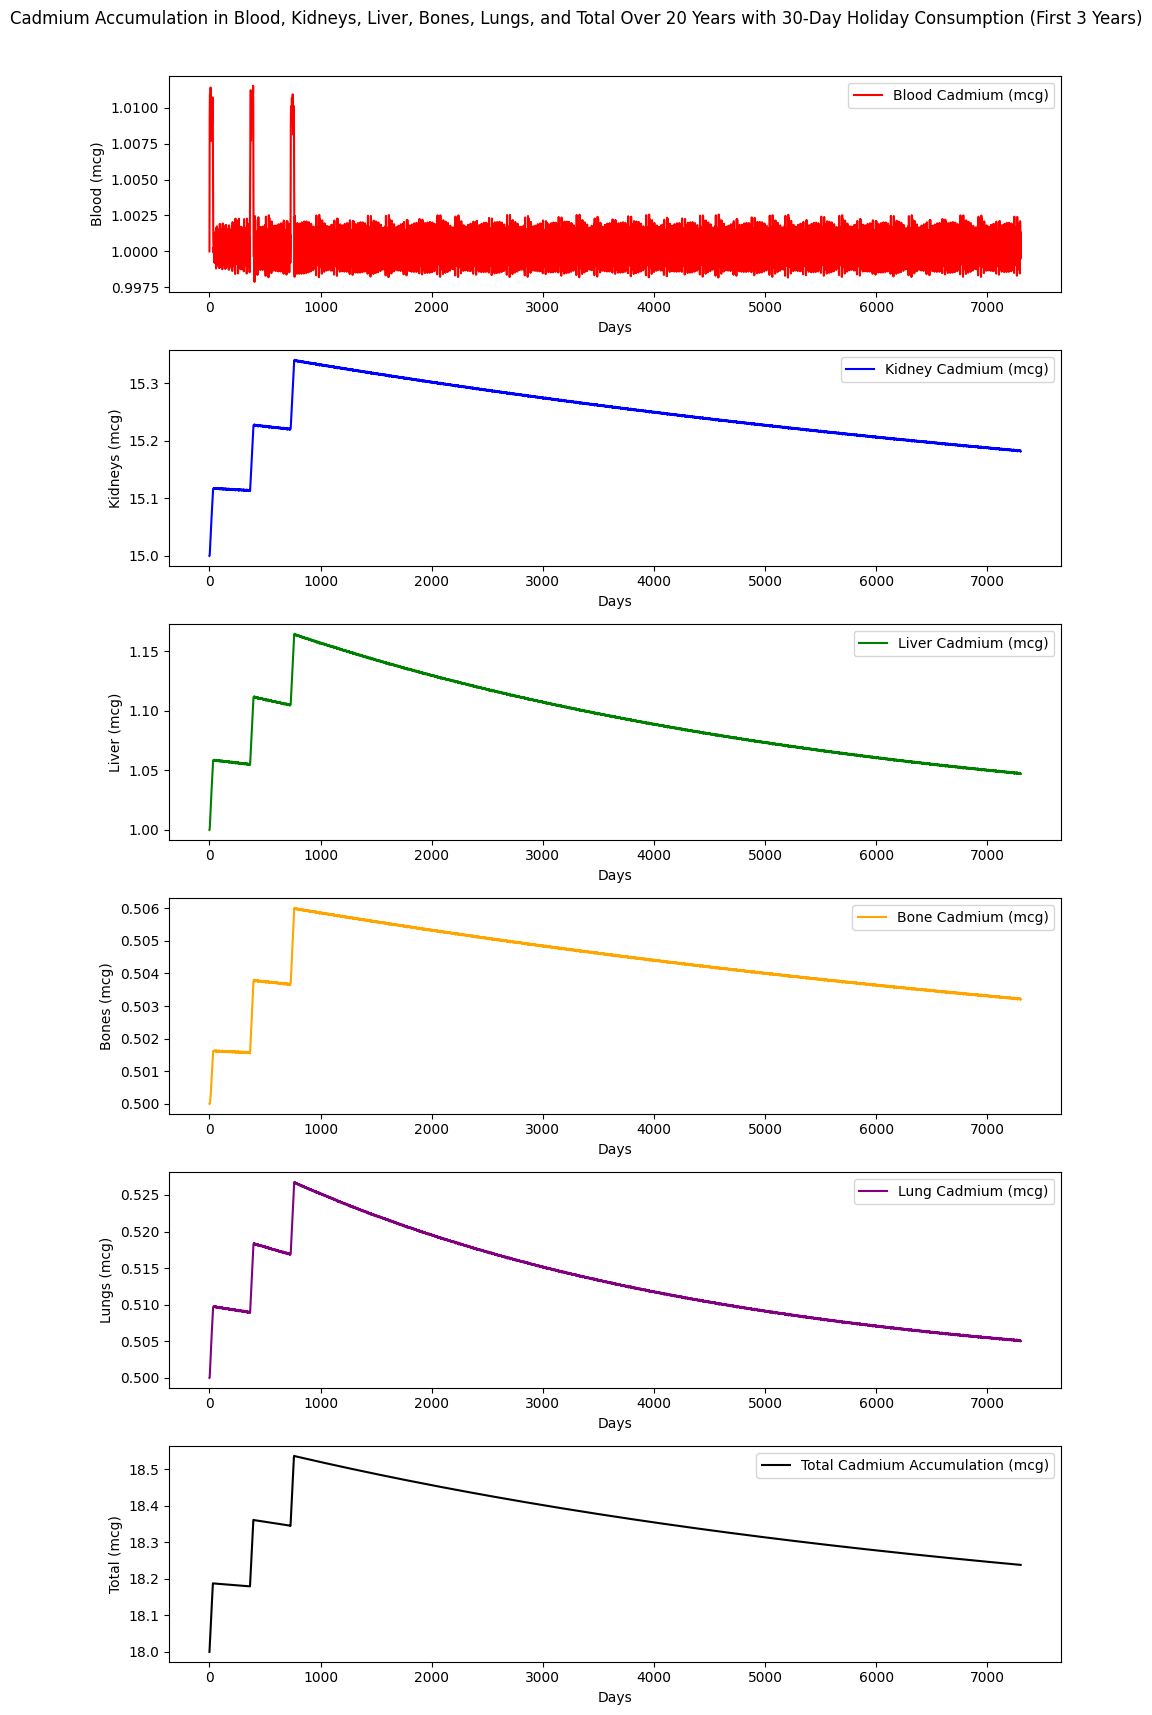

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Nutrient average intakes (mg/day) for children
Fe_avg = 8.5     # Iron
Ca_avg = 900     # Calcium
Zn_avg = 6.5     # Zinc

# Nutrient modulation coefficients
k_Fe = 0.12
k_Ca = 0.06
k_Zn = 0.08

# Baseline cadmium levels (micrograms) in minimally exposed children
baseline_kidneys = 15
baseline_liver = 1
baseline_bones = 0.5
baseline_lungs = 0.5
baseline_blood = 1

# Time-varying functions for Fe, Ca, and Zn levels with weekly fluctuations
def Fe_level(t):
    return Fe_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Ca_level(t):
    return Ca_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Zn_level(t):
    return Zn_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

# Daily cadmium intake during a 30-day holiday period each year for the first 3 years
def baseline_intake(t):
    # Intake only during a 30-day holiday period at the beginning of each year for the first 3 years
    if t < 3 * 365:
        daily_intake = 4.358  # mcg/day from daily chocolate consumption during the holiday
        holiday_intake = daily_intake if (t % 365 < 30) else 0
        return holiday_intake
    else:
        return 0  # No intake after the first 3 years

# Effective intake with nutrient modulation
def effective_intake(t):
    base = baseline_intake(t)
    modulating_factor = 1 / (1 + k_Fe * Fe_level(t) + k_Ca * Ca_level(t) + k_Zn * Zn_level(t))
    return absorption_rate * base * modulating_factor

# Parameters for cadmium intake and initial absorption for children
absorption_rate = 0.08  # Cadmium absorption rate into blood (8% for children)

# Maximum total transfer rates and alpha values based on the target timeframes
R_kidneys_liver_lungs = 0.66  # Maximum total transfer rate for kidneys, liver, and lungs (7-day target)
R_bones = 0.154               # Maximum total transfer rate for bones (30-day target)
alpha_fast = 1                # Faster approach for kidneys, liver, and lungs
alpha_slow = 0.1              # Slower approach for bones

# Time-dependent individual transfer rates as fractions of total transfer
def r_k(t):
    return 0.6 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_l(t):
    return 0.3 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_lungs(t):
    return 0.05 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_b(t):
    return 0.05 * R_bones * (1 - np.exp(-alpha_slow * (t - 1))) if t > 1 else 0

# Excretion rates calculated from half-lives (in days)
excretion_rate_kidneys = np.log(2) / 7300   # Average 20-year half-life
excretion_rate_liver = np.log(2) / 3650     # Average 10-year half-life
excretion_rate_bones = np.log(2) / 7300     # Average 20-year half-life
excretion_rate_lungs = np.log(2) / 2737.5   # Average 7.5-year half-life

# System of differential equations with baseline levels
def cadmium_dynamics(t, C):
    C_blood, C_k, C_l, C_b, C_lungs = C
    intake = effective_intake(t)

    # Blood compartment: gradual transfer to organs after day 1, maintaining baseline
    if t <= 1:
        dCblood_dt = intake
    else:
        dCblood_dt = intake - (r_k(t) + r_l(t) + r_b(t) + r_lungs(t)) * (C_blood - baseline_blood)

    # Organ compartments: start accumulating after day 1, with excretion once accumulation begins
    dCk_dt = r_k(t) * (C_blood - baseline_blood) - excretion_rate_kidneys * (C_k - baseline_kidneys)
    dCl_dt = r_l(t) * (C_blood - baseline_blood) - excretion_rate_liver * (C_l - baseline_liver)
    dCb_dt = r_b(t) * (C_blood - baseline_blood) - excretion_rate_bones * (C_b - baseline_bones)
    dClungs_dt = r_lungs(t) * (C_blood - baseline_blood) - excretion_rate_lungs * (C_lungs - baseline_lungs)

    return [dCblood_dt, dCk_dt, dCl_dt, dCb_dt, dClungs_dt]

# Time span for simulation (20 years in days)
time_span = (0, 20 * 365)  # 20 years in days
initial_conditions = [baseline_blood, baseline_kidneys, baseline_liver, baseline_bones, baseline_lungs]

# Solving the system with daily evaluation intervals
solution = solve_ivp(cadmium_dynamics, time_span, initial_conditions, method='RK45', t_eval=np.arange(0, 20 * 365, 1))

# Calculate total cadmium accumulation as the sum of all organs and blood
total_cadmium = solution.y[0] + solution.y[1] + solution.y[2] + solution.y[3] + solution.y[4]

# Plotting each cadmium accumulation in a separate graph without shared x-axis
fig, axes = plt.subplots(6, 1, figsize=(10, 18))

axes[0].plot(solution.t, solution.y[0], label="Blood Cadmium (mcg)", color="red")
axes[0].set_ylabel("Blood (mcg)")
axes[0].legend()
axes[0].set_xlabel("Days")

axes[1].plot(solution.t, solution.y[1], label="Kidney Cadmium (mcg)", color="blue")
axes[1].set_ylabel("Kidneys (mcg)")
axes[1].legend()
axes[1].set_xlabel("Days")

axes[2].plot(solution.t, solution.y[2], label="Liver Cadmium (mcg)", color="green")
axes[2].set_ylabel("Liver (mcg)")
axes[2].legend()
axes[2].set_xlabel("Days")

axes[3].plot(solution.t, solution.y[3], label="Bone Cadmium (mcg)", color="orange")
axes[3].set_ylabel("Bones (mcg)")
axes[3].legend()
axes[3].set_xlabel("Days")

axes[4].plot(solution.t, solution.y[4], label="Lung Cadmium (mcg)", color="purple")
axes[4].set_ylabel("Lungs (mcg)")
axes[4].legend()
axes[4].set_xlabel("Days")

axes[5].plot(solution.t, total_cadmium, label="Total Cadmium Accumulation (mcg)", color="black")
axes[5].set_ylabel("Total (mcg)")
axes[5].set_xlabel("Days")
axes[5].legend()

fig.suptitle("Cadmium Accumulation in Blood, Kidneys, Liver, Bones, Lungs, and Total Over 20 Years with 30-Day Holiday Consumption (First 3 Years)")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# Binge


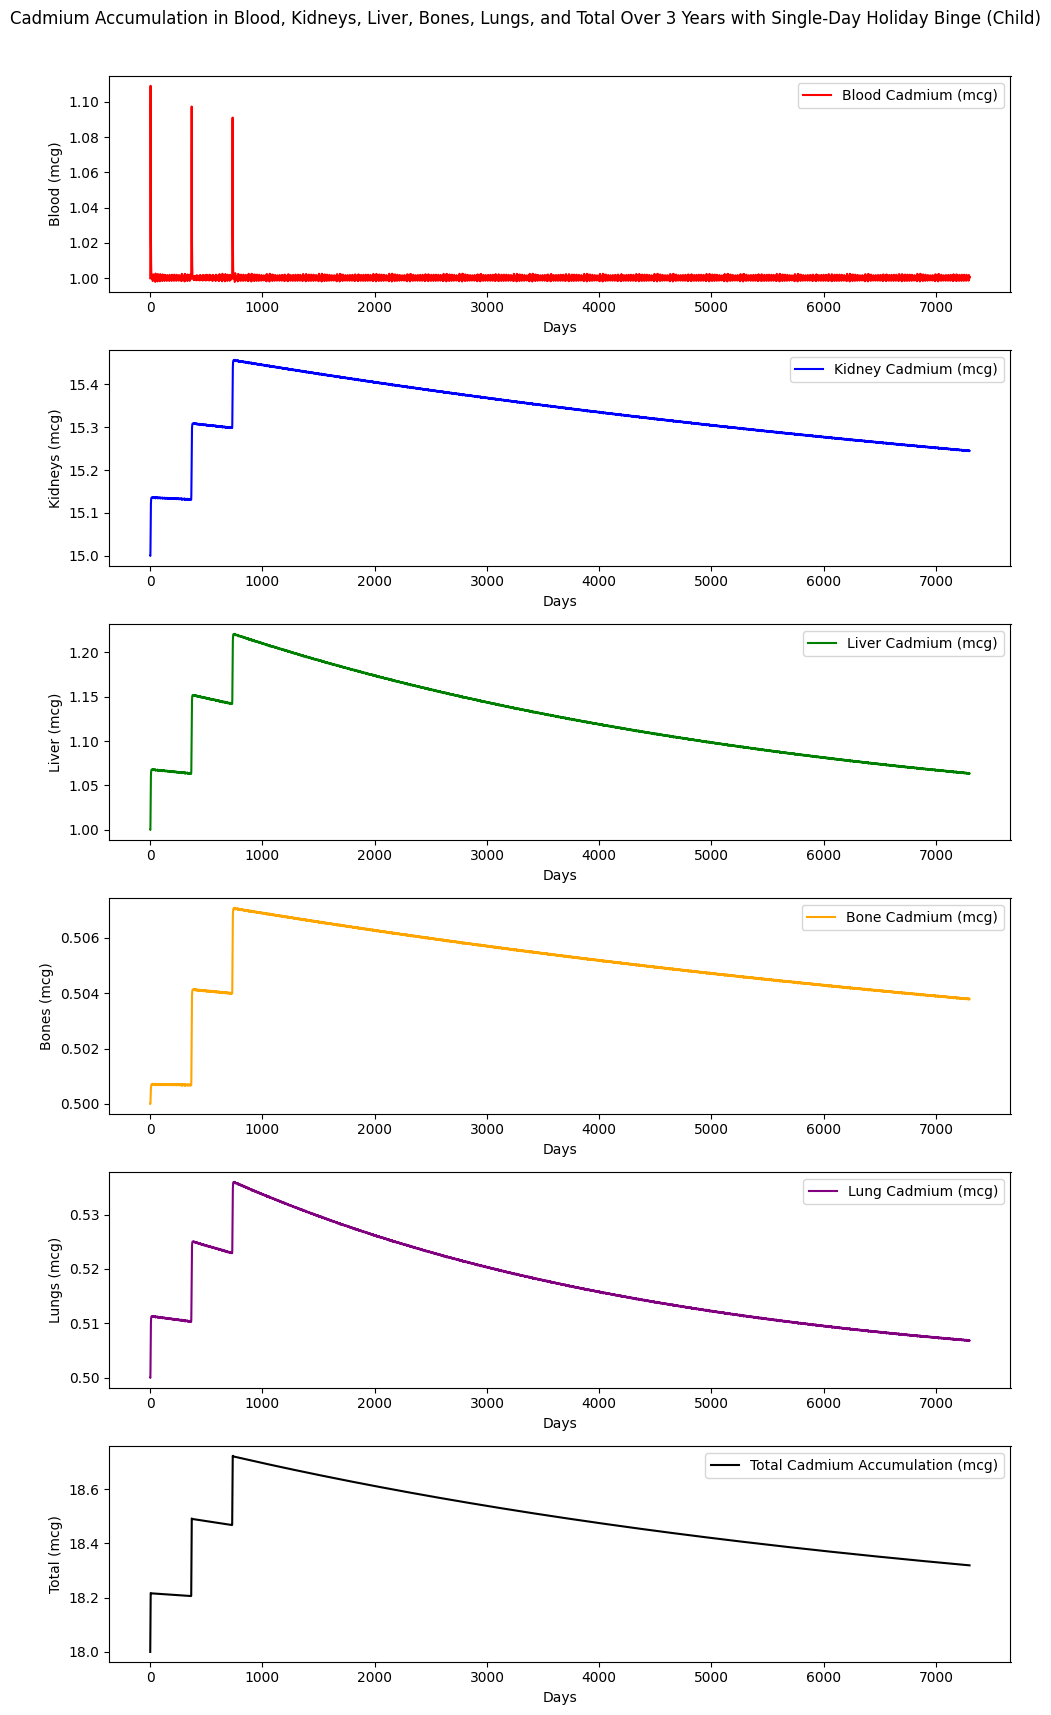

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Nutrient average intakes (mg/day) for children
Fe_avg = 8.5     # Iron
Ca_avg = 900     # Calcium
Zn_avg = 6.5     # Zinc

# Nutrient modulation coefficients
k_Fe = 0.12
k_Ca = 0.06
k_Zn = 0.08

# Baseline cadmium levels (micrograms) in minimally exposed children
baseline_kidneys = 15
baseline_liver = 1
baseline_bones = 0.5
baseline_lungs = 0.5
baseline_blood = 1

# Time-varying functions for Fe, Ca, and Zn levels with weekly fluctuations
def Fe_level(t):
    return Fe_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Ca_level(t):
    return Ca_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

def Zn_level(t):
    return Zn_avg * (1 + 0.1 * np.sin(2 * np.pi * t / 7))

# Daily cadmium intake with a binge (10x) during a 1-day holiday each year for the first 3 years
def baseline_intake(t):
    # Intake only on a 1-day holiday at the beginning of each year for the first 3 years
    if t < 3 * 365:
        daily_intake = 4.358  # mcg/day from daily chocolate consumption
        holiday_intake = 10 * daily_intake if (t % 365 < 4) else 0
        return holiday_intake
    else:
        return 0  # No intake after the first 3 years

# Effective intake with nutrient modulation
def effective_intake(t):
    base = baseline_intake(t)
    modulating_factor = 1 / (1 + k_Fe * Fe_level(t) + k_Ca * Ca_level(t) + k_Zn * Zn_level(t))
    return absorption_rate * base * modulating_factor

# Parameters for cadmium intake and initial absorption for children
absorption_rate = 0.08  # Cadmium absorption rate into blood (8% for children)

# Maximum total transfer rates and alpha values based on the target timeframes
R_kidneys_liver_lungs = 0.66  # Maximum total transfer rate for kidneys, liver, and lungs (7-day target)
R_bones = 0.154               # Maximum total transfer rate for bones (30-day target)
alpha_fast = 1                # Faster approach for kidneys, liver, and lungs
alpha_slow = 0.1              # Slower approach for bones

# Time-dependent individual transfer rates as fractions of total transfer
def r_k(t):
    return 0.6 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_l(t):
    return 0.3 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_lungs(t):
    return 0.05 * R_kidneys_liver_lungs * (1 - np.exp(-alpha_fast * (t - 1))) if t > 1 else 0

def r_b(t):
    return 0.05 * R_bones * (1 - np.exp(-alpha_slow * (t - 1))) if t > 1 else 0

# Excretion rates calculated from half-lives (in days)
excretion_rate_kidneys = np.log(2) / 7300   # Average 20-year half-life
excretion_rate_liver = np.log(2) / 3650     # Average 10-year half-life
excretion_rate_bones = np.log(2) / 7300     # Average 20-year half-life
excretion_rate_lungs = np.log(2) / 2737.5   # Average 7.5-year half-life

# System of differential equations with baseline levels
def cadmium_dynamics(t, C):
    C_blood, C_k, C_l, C_b, C_lungs = C
    intake = effective_intake(t)

    # Blood compartment: gradual transfer to organs after day 1, maintaining baseline
    if t <= 1:
        dCblood_dt = intake
    else:
        dCblood_dt = intake - (r_k(t) + r_l(t) + r_b(t) + r_lungs(t)) * (C_blood - baseline_blood)

    # Organ compartments: start accumulating after day 1, with excretion once accumulation begins
    dCk_dt = r_k(t) * (C_blood - baseline_blood) - excretion_rate_kidneys * (C_k - baseline_kidneys)
    dCl_dt = r_l(t) * (C_blood - baseline_blood) - excretion_rate_liver * (C_l - baseline_liver)
    dCb_dt = r_b(t) * (C_blood - baseline_blood) - excretion_rate_bones * (C_b - baseline_bones)
    dClungs_dt = r_lungs(t) * (C_blood - baseline_blood) - excretion_rate_lungs * (C_lungs - baseline_lungs)

    return [dCblood_dt, dCk_dt, dCl_dt, dCb_dt, dClungs_dt]

# Time span for simulation (3 years in days)
time_span = (0, 20 * 365)  # 3 years in days
initial_conditions = [baseline_blood, baseline_kidneys, baseline_liver, baseline_bones, baseline_lungs]

# Solving the system with daily evaluation intervals
solution = solve_ivp(cadmium_dynamics, time_span, initial_conditions, method='RK45', t_eval=np.arange(0, 20 * 365, 1))

# Calculate total cadmium accumulation as the sum of all organs and blood
total_cadmium = solution.y[0] + solution.y[1] + solution.y[2] + solution.y[3] + solution.y[4]

# Plotting each cadmium accumulation in a separate graph without shared x-axis
fig, axes = plt.subplots(6, 1, figsize=(10, 18))

axes[0].plot(solution.t, solution.y[0], label="Blood Cadmium (mcg)", color="red")
axes[0].set_ylabel("Blood (mcg)")
axes[0].legend()
axes[0].set_xlabel("Days")

axes[1].plot(solution.t, solution.y[1], label="Kidney Cadmium (mcg)", color="blue")
axes[1].set_ylabel("Kidneys (mcg)")
axes[1].legend()
axes[1].set_xlabel("Days")

axes[2].plot(solution.t, solution.y[2], label="Liver Cadmium (mcg)", color="green")
axes[2].set_ylabel("Liver (mcg)")
axes[2].legend()
axes[2].set_xlabel("Days")

axes[3].plot(solution.t, solution.y[3], label="Bone Cadmium (mcg)", color="orange")
axes[3].set_ylabel("Bones (mcg)")
axes[3].legend()
axes[3].set_xlabel("Days")

axes[4].plot(solution.t, solution.y[4], label="Lung Cadmium (mcg)", color="purple")
axes[4].set_ylabel("Lungs (mcg)")
axes[4].legend()
axes[4].set_xlabel("Days")

axes[5].plot(solution.t, total_cadmium, label="Total Cadmium Accumulation (mcg)", color="black")
axes[5].set_ylabel("Total (mcg)")
axes[5].set_xlabel("Days")
axes[5].legend()

fig.suptitle("Cadmium Accumulation in Blood, Kidneys, Liver, Bones, Lungs, and Total Over 3 Years with Single-Day Holiday Binge (Child)")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
